In [ ]:
import tensorflow as tf 
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
## SAVED A COPY OF SINGE STAGE MODEL IN GOOGLE DRIVE ON 20/9/2020 AND THEM CHANGED MODEL TO DO 3 STAGE MODELLING

In [ ]:
from google.colab import drive 
drive.mount('/mntDrive')

Mounted at /mntDrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive

'Colab Notebooks'   drg_via		  pgeocode_to_rohan.ipynb
 drgs		    master_co_data.xlsx


In [ ]:
import numpy as np
import math
import pandas as pd
import cv2
import os
import tqdm
from scipy.io import loadmat

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from PIL import Image
# import pytesseract

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import backend as K

# from utils import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, SGD
from keras.layers import *

# from keras.applications import MobileNetV2
# from keras.applications import InceptionResNetV2

from keras.models import Model
from keras.models import model_from_json

from keras.initializers import he_normal


In [ ]:
target_size = [608, 608]
target_w = 608 # target sizes of image in model input
target_h = 608 #target sizes of image in model input

grid_size = [19, 19]
grid_y_axis = 19  # each image is to be segmented to 17 x 17 grid
grid_x_axis = 19  # # each image is to be segmented to 17 x 17 grid

grid_stride = target_w / grid_x_axis  # grid cell width
grid_stride = target_h / grid_y_axis  # grid cell height

channels = 3
num_anchors = 3
class_num = 1     ## item
info = 5 + class_num    # pc, x, y, h, w, and class probabilities

categories = ['bom'] # details of classes

In [ ]:
# Making a list of image path

drg_directory = '/content/drive/My Drive/drgs'
drg_image = ['/content/drive/My Drive/drgs/{}'.format(i) for i in os.listdir(drg_directory)] # making the list
drg_image.sort() # Sorting the list

#num_images = len(drg_image_1) +len(drg_image_2) + len(drg_image_3) + len(drg_image_4)
num_images = len(drg_image)

print('Number of images = ', num_images)


Number of images =  571


In [ ]:
# Check sizes of exiting images & Create a Dataframe with image id and height(row) and width(column):

rows = []
columns = []
image_sl = []
df_new = pd.DataFrame()

for i in range(len(drg_image)):
    image = cv2.imread(drg_image[i]) ## Loading image
    height, width, _ = image.shape
    rows.append(height)
    columns.append(width)
    image_sl.append(drg_image[i])
print(len(rows))      
row_values = pd.Series(rows)
col_values = pd.Series(columns)
image_num = pd.Series(image_sl)


df_new.insert(loc=0, column='image_serial', value=image_num)
df_new.insert(loc=1, column='rows', value=row_values)
df_new.insert(loc=2, column='columns', value=col_values)

df_new.tail(3)

571


image_serial  rows  columns
568  /content/drive/My Drive/drgs/9718-19-SRZ-02-00...  2479     3508
569  /content/drive/My Drive/drgs/9718-19-SRZ-04-05...  2479     3508
570  /content/drive/My Drive/drgs/JR-606-18.5@1000-...  1275     1650

In [ ]:
df_new.to_csv(r'/content/drive/My Drive/df_new.csv', index = False )

In [ ]:
df_new = pd.read_csv('/content/drive/My Drive/df_new.csv', header = 0)
df_new.tail(3)

image_serial  rows  columns
568  /content/drive/My Drive/drgs/9718-19-SRZ-02-00...  2479     3508
569  /content/drive/My Drive/drgs/9718-19-SRZ-04-05...  2479     3508
570  /content/drive/My Drive/drgs/JR-606-18.5@1000-...  1275     1650

In [ ]:
# Loading output of VGG Image Annotation tool and create a dataframe

r_data = pd.DataFrame()

r_data_1 = pd.read_csv('/content/drive/My Drive/drg_via/via_region_data_drg_test_1.csv')
r_data_2 = pd.read_csv('/content/drive/My Drive/drg_via/via_region_data_drg_test_2.csv')
r_data_3 = pd.read_csv('/content/drive/My Drive/drg_via/via_region_data_drg_test_3.csv')
r_data_4 = pd.read_csv('/content/drive/My Drive/drg_via/via_region_data_drg_test_4.csv')
r_data_5 = pd.read_csv('/content/drive/My Drive/drg_via/via_region_data_drg_test_5.csv')
r_data_6 = pd.read_csv('/content/drive/My Drive/drg_via/via_region_data_drg_test_6.csv')
r_data_7 = pd.read_csv('/content/drive/My Drive/drg_via/via_region_data_drg_test_7.csv')
r_data_8 = pd.read_csv('/content/drive/My Drive/drg_via/via_region_data_drg_test_8.csv')
r_data_9 = pd.read_csv('/content/drive/My Drive/drg_via/via_region_data_drg_test_9.csv')
r_data_10 = pd.read_csv('/content/drive/My Drive/drg_via/via_region_data_drg_test_10.csv')
r_data_11 = pd.read_csv('/content/drive/My Drive/drg_via/via_region_data_drg_test_11.csv')
r_data_13 = pd.read_csv('/content/drive/My Drive/drg_via/via_region_data_drg_test_13.csv')

r_data = pd.concat([r_data_1, r_data_2, r_data_3, r_data_4, r_data_5, r_data_6, r_data_7, r_data_8, r_data_9, r_data_10, r_data_11, r_data_13], axis = 0, ignore_index = True)

r_data_master = r_data[~r_data['region_shape_attributes'].str.contains('{}')].reset_index(drop=True)
r_data_to_drop = r_data[r_data['region_shape_attributes'].str.contains('{}')].reset_index(drop=True) # to remove no region drg

image_drop_list = r_data_to_drop['#filename'].tolist()

for i in image_drop_list:
    img_id = '/content/drive/My Drive/drgs/'+ i
    # print('In drgs folder = ', img_id)
    drg_image.remove(img_id) # remove the image from image list

drg_image.sort()

# r_data = pd.concat([r_data_1_master, r_data_2_master, r_data_3_master, r_data_4_master, r_data_5_master, r_data_6_master, r_data_7_master, r_data_8_master, r_data_9_master, r_data_10_master], axis = 0, ignore_index = True)

num_obj = r_data_master['region_count'][0] # number of objects in each photo
r_data_master.drop(r_data_master.columns[[1, 2, 3, 4]], axis=1, inplace=True) # reduce unnecessary columns

r_data_master.sort_values(by=['#filename'], ascending=True) # Sorting based on image-id
num_images = r_data_master["#filename"].nunique() # Find out number of unique images

print('Number of unique images = ', num_images)
print('Number of images with region data = ', len(r_data_master))
print('Number of drawings in image file = ', len(drg_image))



Number of unique images =  561
Number of images with region data =  561
Number of drawings in image file =  562


In [ ]:
# Making a dataframe for Image_id, x, y, width, height, class, image_width and image_height

x = []
y = []
width = []
height = []
obj_class = []
i_width = []
i_height = []
img_path = []
img_index = []

for i in range(len(r_data_master)):
    
    r_size = r_data_master.values[i, 1][1:(len(r_data_master.values[i, 1])-1)]
    r_size_par = r_size.split(",")
    
#    print(i)
    
    x.append(int("".join(filter(str.isdigit, r_size_par[1]))))
#    print('=================================================')
    y.append(int("".join(filter(str.isdigit, r_size_par[2]))))
    width.append(int("".join(filter(str.isdigit, r_size_par[3]))))
    height.append(int("".join(filter(str.isdigit, r_size_par[4]))))
    
    r_attribs = r_data_master.values[i, 2][1:(len(r_data_master.values[i, 2])-1)]
    r_attribs_par = r_attribs.split(':')[1]
    obj_class.append(r_attribs_par[1:(len(r_attribs_par)-1)])
    
    foto_id = r_data_master['#filename'][i]

    i_path = '/content/drive/My Drive/drgs/' + foto_id
    # print(i)
    # print(i_path)
    # print('====================================')
    foto_index = int(df_new[df_new['image_serial'] == i_path].index[0])
    foto_width = df_new['columns'][foto_index]
    foto_height = df_new['rows'][foto_index]
    i_width.append(foto_width)
    i_height.append(foto_height)
    img_path.append(i_path)
    img_index.append(foto_index)
    
x_values = pd.Series(x)
y_values = pd.Series(y)
width_values = pd.Series(width)
height_values = pd.Series(height)
class_values = pd.Series(obj_class)
i_width_values = pd.Series(i_width)
i_height_values = pd.Series(i_height)
img_path_values = pd.Series(img_path)
img_index_values = pd.Series(img_index)

r_data_master.insert(loc=1, column='img_idx', value=img_index_values)
r_data_master.insert(loc=2, column='i_path', value=img_path_values)
r_data_master.insert(loc=3, column='x', value=x_values)
r_data_master.insert(loc=4, column='y', value=y_values)
r_data_master.insert(loc=5, column='width', value=width_values)
r_data_master.insert(loc=6, column='height', value=height_values)
r_data_master.insert(loc=7, column='obj_class', value=class_values)
r_data_master.insert(loc=8, column='img_wd', value=i_width_values)
r_data_master.insert(loc=9, column='img_ht', value=i_height_values)

r_data_master.drop(r_data_master.columns[[10, 11]], axis=1, inplace=True) # reduce unnecessary columns

r_data_master.rename({'#filename': 'img_id'}, axis=1, inplace=True) # changing column name

r_data_master.tail(3)


img_id  img_idx  ... img_wd  img_ht
558      11686-21-FUF-01-06-Model-page-001.jpg      452  ...   1650    1275
559      11686-21-FUF-01-07-Model-page-001.jpg      453  ...   1650    1275
560  JR-606-18.5@1000-02-00-Model-page-001.jpg      570  ...   1650    1275

[3 rows x 10 columns]

In [ ]:
def single_image_info(lines):
    
    ## lines will be a dataframe like, for i in range(num_images), lines = r_new_data[i*5:(i+1)*5]
    
    line_idx = lines.iat[0, 1]
    pic_path = lines.iat[0, 2]
    img_width = lines.iat[0, 8]
    img_height = lines.iat[0, 9]
    
    boxes = []
    labels = []
    for i in range(len(lines)):
        
        index_of = lines['obj_class'][i]
        label = categories.index(index_of)
        x_min, y_min, x_max, y_max = float(lines.iat[i,3]), float(lines.iat[i,4]), float(lines.iat[i,3]+lines.iat[i,5]), float(lines.iat[i,4]+lines.iat[i,6])
        boxes.append([x_min, y_min, x_max, y_max])
        labels.append(label)
        
    boxes = np.asarray(boxes, np.float32)
    labels = np.asarray(labels, np.int64)
    
    return line_idx, pic_path, boxes, labels, img_width, img_height  ## boxes are in format xmin, ymin, xmax, ymax


In [ ]:
## Creating the complete data set :

all_image_line = []
limit_lower = 0
limit_upper = 0

for i in range(num_images):

    image_line = []
    
    img = r_data_master['img_id'][limit_upper]
    kount = r_data_master['img_id'].value_counts()[img]      ## this gives no. of same images with region data of multiple categories
       
    limit_lower = limit_upper
    limit_upper = limit_lower + kount
    
    lines = r_data_master[limit_lower:limit_upper].reset_index(drop=True)
    """
    print('===================', i)
    print(img)
    print(limit_lower)
    print(limit_upper)
    """
    
    line_idx, pic_path, boxes, labels, img_width, img_height = single_image_info(lines)
    image_line.append(line_idx)                                                                  ## line_idx = index of the same image in df_new dataframe
    image_line.append(pic_path)                                                                  ## pic_path = path of the image
    image_line.append(boxes)                                                                     ## boxes are in format xmin, ymin, xmax, ymax
    image_line.append(labels)                                                                    ## labels are in form of index no. in 'categories' list 
    image_line.append(img_width)
    image_line.append(img_height)
    all_image_line.append(image_line)
    
print(len(all_image_line))
print(all_image_line[100])   ##  boxes are in format xmin, ymin, xmax, ymax

561
[300, '/content/drive/My Drive/drgs/1103.jpg', array([[2202., 1597., 3193., 1826.]], dtype=float32), array([0]), 3509, 2480]


In [ ]:
print('Number of unique images = ', r_data_master['img_id'].nunique())  # print total no, of unique images
print('Number of classes in diff. categories = ', r_data_master['obj_class'].value_counts())

Number of unique images =  561
Number of classes in diff. categories =  bom    561
Name: obj_class, dtype: int64


In [ ]:
# Train and Test split

data_train, data_val = train_test_split(all_image_line, train_size = 0.90 , shuffle = True)

num_all_bbox = len(all_image_line) * len(all_image_line[0][2])
num_bb_train = len(data_train) * len(data_train[0][2])
num_bb_val = len(data_val) * len(data_val[0][2])
print(num_all_bbox, num_bb_train, num_bb_val)

561 504 57


In [ ]:
## calculating anchors from true boundary boxes :

def iou_kmeans(box, clusters):
    """
    Calculates the Intersection over Union (IoU) between a box and k clusters.
    :param box: tuple or array, shifted to the origin (i. e. width and height)
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: numpy array of shape (k, 0) where k is the number of clusters
    """
    x = np.minimum(clusters[:, 0], box[0])
    y = np.minimum(clusters[:, 1], box[1])
    if np.count_nonzero(x == 0) > 0 or np.count_nonzero(y == 0) > 0:
        raise ValueError("Box has no area")

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou = intersection / (box_area + cluster_area - intersection)

    return iou

def kmeans(boxes, k, dist=np.median):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances = np.empty((rows, k))
    last_clusters = np.zeros((rows,))

    np.random.seed()

    # the Forgy method will fail if the whole array contains the same rows
    clusters = boxes[np.random.choice(rows, k, replace=False)]


    while True:
        for row in range(rows):
            distances[row] = 1 - iou_kmeans(boxes[row], clusters)

        nearest_clusters = np.argmin(distances, axis=1)

        if (last_clusters == nearest_clusters).all():
            break

        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters

In [ ]:
# Finding out anchors :
## Firstly, converting true boundary box width, height to width & height with respect to target image :
## finally find anchors. Anchors here are in absolute size w.r.t. target image but not as % of target image or 
## as multiple of unit grids.

num_all_bb = len(r_data_master) # if no. of bboxes varies for images, this formula should be used 

anchors_wrt_target = np.zeros((3,2))

# num_all_bb = len(all_image_line) * len(all_image_line[0][2])  ## from all image line data, this formula to be used if no. of bboxes are same for all images

b_box_wrt_target = np.zeros((num_all_bb,2))

for i in range(num_all_bb):
    
    image_w = r_data_master['img_wd'][i]
    image_h = r_data_master['img_ht'][i]

    x_ratio = target_w / image_w 
    y_ratio = target_h / image_h

    # x_ratio = 1.    ## since we shall only pad the images 
    # y_ratio = 1.    ## since we shall only pad the images
    
    anchor_w = r_data_master['width'][i] * x_ratio
    anchor_h = r_data_master['height'][i] * y_ratio
    b_box_wrt_target[i, 0] = anchor_w
    b_box_wrt_target[i, 1] = anchor_h
    
anchors_wrt_target = kmeans(b_box_wrt_target, num_anchors)

print(anchors_wrt_target.shape)
print(anchors_wrt_target)     ## anchors wrt target image in abs. value and in format width, height

(3, 2)
[[179.21094641  92.21782977]
 [179.21094641  48.80677693]
 [178.51767389 151.81605486]]


In [ ]:
anchors_50 = [179.21094641, 92.21782977, 179.21094641, 48.80677693, 178.51767389, 151.81605486]
anchors_50 = np.reshape(anchors_wrt_target, [3,2])
anchors_50

array([[179.21094641,  92.21782977],
       [179.21094641,  48.80677693],
       [178.51767389, 151.81605486]])

In [ ]:
## Pre-processing the original data to get y_true :

def process_box(ori_boxes, ori_img_width, ori_img_height, labels, target_size, class_num, anchors):
    '''
    Generate the y_true label, i.e. the ground truth feature_map.
    params:
        boxes: [N, 5] shape, float32 dtype. `x_min, y_min, x_max, y_mix, mixup_weight`.
        labels: [N] shape, int64 dtype.
        class_num: int64 num.
        anchors: [3,2] shape, float32 dtype.
    '''
    
    img_width = ori_img_width
    img_height = ori_img_height
    boxes = ori_boxes           ## boxes in format xmin, ymin, xmax, ymax
  
    x_ratio = target_size[1] / img_width
    y_ratio = target_size[0] / img_height
    

    
    
    
    boxes_wrt_target = np.zeros((1,4))
    box_centers_target = np.zeros((1,2))

    boxes_wrt_target[:,0] = boxes[:,0] * x_ratio  # xmin absolute value wrt target image
    boxes_wrt_target[:,1] = boxes[:,1] * y_ratio  # ymin absolute value wrt target image
    boxes_wrt_target[:,2] = boxes[:,2] * x_ratio  # xmax absolute value wrt target image
    boxes_wrt_target[:,3] = boxes[:,3] * y_ratio  # ymax absolute value wrt target image
    
    # In above, boxes_wrt_target shape is (5, 4), now this will be taken to (5. 5) by adding 1 at end
#    boxes_wrt_target = np.concatenate((boxes_wrt_target, np.full(shape=(boxes_wrt_target.shape[0], 1), fill_value=1., dtype=np.float32)), axis=-1)
    box_centers_target = (boxes_wrt_target[:, 0:2] + boxes_wrt_target[:, 2:4]) / 2  ## centers wrt target, abs values
    
    box_sizes = boxes[:, 2:4] - boxes[:, 0:2]  #xmax-xmin = width and ymax-ymin = height wrt original image
    box_sizes[:,0] = box_sizes[:,0] * x_ratio  # width w.r.t target image in absolute value
    box_sizes[:,1] = box_sizes[:,1] * y_ratio  # width w.r.t target image in absolute value
    
#    y_true_13 = np.zeros((target_size[1] // 32, target_size[0] // 32, 3, 6 + class_num), np.float32)
    y_true_13 = np.zeros((target_size[1] // 32, target_size[0] // 32, 3, 5 + class_num), np.float32)

#    y_true = [y_true_13]
    
    box_sizes = np.expand_dims(box_sizes, 1)
    mins = np.maximum(- box_sizes / 2, - anchors / 2)
    maxs = np.minimum(box_sizes / 2, anchors / 2)
    whs = maxs - mins

    iou = (whs[:, :, 0] * whs[:, :, 1]) / (
                box_sizes[:, :, 0] * box_sizes[:, :, 1] + anchors[:, 0] * anchors[:, 1] - whs[:, :, 0] * whs[:, :,
                                                                                                         1] + 1e-10)
    best_match_idx = np.argmax(iou, axis=1)
    
#    print(best_match_idx)

    anchor_mask = np.zeros((target_size[1] // 32, target_size[0] // 32, 3))

    grid_stride = 32  ## = targetsize / no. of grid cells
    
    for i, idx in enumerate(best_match_idx):

        x = int(np.floor(box_centers_target[i, 0] / grid_stride))
        y = int(np.floor(box_centers_target[i, 1] / grid_stride))
        k = int(idx)
        c = int(labels[i])

#        print(x, y, k, c)
        

# Very Imp : Now preparing y_true: all values x_center, y_cemter, width & height are being taken to % of target image
        
        y_true_13[y, x, k, :2] = box_centers_target[i] / target_size[0] #since target_size[0] = target_size[1]
        y_true_13[y, x, k, 2:4] = box_sizes[i] / target_size[0]
        y_true_13[y, x, k, 4] = 1.
        y_true_13[y, x, k, 5 + c] = 1.
#        y_true[0][y, x, k, -1] = boxes_wrt_target[i, -1]
        anchor_mask[y, x, k] = 1
#        print(y_true_13[y,x])

    return y_true_13, anchor_mask  ## all data are w.r.to target image in % of target image and NOT w,r,t, grid cells


In [ ]:
## Single image-wise image/boundary box preprocessing:

def parse_data(line, class_num, target_size, anchors):   ## (mode, letterbox_resize):
    '''
    param:
        line: a line from the training/test txt file
        class_num: totol class nums.
        target_size: the size of image to be resized to. [width, height] format.
        anchors: anchors.
        mode: 'train' or 'val'. When set to 'train', data_augmentation will be applied.
        letterbox_resize: whether to use the letterbox resize, i.e., keep the original aspect ratio in the resized image.
    '''
    
    img_idx, pic_path, boxes, labels,img_width, img_height = line  # boxes in format xmin, ymin, xmax, ymax
    img = cv2.imread(pic_path)
    img_resized = cv2.resize(img,(target_size[0], target_size[1]))
    
#    img_resized = unsharp_mask(img_resized)
    
#    img_resized, pad_top, pad_bottom = pad_images_to_same_size(img)
    
#    image_height = img_height + pad_top + pad_bottom
    
    # expand the 2nd dimension, mix up weight default to 1.
#    boxes = np.concatenate((boxes, np.full(shape=(boxes.shape[0], 1), fill_value=1., dtype=np.float32)), axis=-1)
 
    img_resized = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB).astype(np.float32)

    # the input of yolo_v3 should be in range 0~1, lets change to -0.5 to +0.5
    img_resized = (img_resized - 127.5)/ 255.

    y_true_13, anchor_mask = process_box(boxes, img_width, img_height, labels, target_size, class_num, anchors)

    return img_idx, img_resized, y_true_13, anchor_mask


In [ ]:
## Making the data ready for entering into network :

anchors = anchors_wrt_target
image_index = []
image_resized = []
image_y_true = []
image_anchor_mask = []

for i in range(len(data_train)):

    line = data_train[i]
    
    img_idx, img_resized, y_true, anchor_mask = parse_data(line, class_num, target_size, anchors)
    
    
    image_index.append(img_idx)
    image_resized.append(img_resized)
    image_y_true.append(y_true)
    image_anchor_mask.append(anchor_mask)
    # print('train img_index. = ', img_idx)
    # print('train sl. no. = ', i)
    if i == 100:
      print('=============================')
    if i == 400:
      print('+++++++++++++++++++++++++++++++++')
train_image_index = image_index
X_train = np.array(image_resized).astype(np.float32)
Y_train = np.array(image_y_true).astype(np.float32)
train_anchor_mask = np.array(image_anchor_mask).astype(np.float32)

image_index = []
image_resized = []
image_y_true = []
image_anchor_mask = []

for i in range(len(data_val)):
    line = data_val[i]
    
    
    img_idx, img_resized, y_true, anchor_mask = parse_data(line, class_num, target_size, anchors)
    
    image_index.append(img_idx)
    image_resized.append(img_resized)
    image_y_true.append(y_true)
    image_anchor_mask.append(anchor_mask)
    #print('val img_index. = ', img_idx)
    #print('val sl. no. = ', i)
    if i == 50:
      print('#######################################################')
    #print('=============================')
    
val_image_index = image_index
X_val = np.array(image_resized).astype(np.float32)
Y_val = np.array(image_y_true).astype(np.float32)
val_anchor_mask = np.array(image_anchor_mask).astype(np.float32)

image_index = []
image_resized = []
image_y_true = []


+++++++++++++++++++++++++++++++++
#######################################################


In [ ]:
r_data_master['img_id'][300].split('.')[0]

'10608-1-20-SRE-01-02-Model-page-001'

In [ ]:
def xywh_to_x1y1x2y2(box):
    xy = box[..., 0:2]
    wh = box[..., 2:4]

    x1y1 = xy - wh / 2
    x2y2 = xy + wh / 2

    y_box = K.concatenate([x1y1, x2y2], axis=-1)
    return y_box

def broadcast_iou(box_a, box_b):
    """
    calculate iou between box_a and multiple box_b in a broadcast way
    inputs: box_a: a tensor full of boxes, eg. (B, N, 4), box is in x1y1x2y2
            box_b: another tensor full of boxes, eg. (B, M, 4)
    """

    # (B, N, 1, 4)
    box_a = tf.expand_dims(box_a, -2)
    # (B, 1, M, 4)
    box_b = tf.expand_dims(box_b, -3)
    # (B, N, M, 4)
    new_shape = tf.broadcast_dynamic_shape(tf.shape(box_a), tf.shape(box_b))

    # (B, N, M, 4)
    # (B, N, M, 4)
    box_a = tf.broadcast_to(box_a, new_shape)
    box_b = tf.broadcast_to(box_b, new_shape)

    # (B, N, M, 1)
    al, at, ar, ab = tf.split(box_a, 4, -1)
    bl, bt, br, bb = tf.split(box_b, 4, -1)

    # (B, N, M, 1)
    left = tf.math.maximum(al, bl)
    right = tf.math.minimum(ar, br)
    top = tf.math.maximum(at, bt)
    bot = tf.math.minimum(ab, bb)

    # (B, N, M, 1)
    iw = tf.clip_by_value(right - left, 0, 1)
    ih = tf.clip_by_value(bot - top, 0, 1)
    i = iw * ih

    # (B, N, M, 1)
    area_a = (ar - al) * (ab - at)
    area_b = (br - bl) * (bb - bt)
    union = area_a + area_b - i

    # (B, N, M)
    iou = tf.squeeze(i / (union + 1e-7), axis=-1)

    return iou

## https://github.com/ethanyanjiali/deep-vision/blob/master/YOLO/tensorflow/yolov3.py#L213

def calc_ignore_mask(ignore_thresh, true_box, pred_box):
    
        # YOLOv3:
        # "If the bounding box prior is not the best but does overlap a ground
        # truth object by more than some threshold we ignore the prediction,
        # following [17]. We use the threshold of .5."
        # calculate the iou for each pair of pred bbox and true bbox, then find the best among them

        # (None, 13, 13, 3, 4)
        
        true_box_reorganised = xywh_to_x1y1x2y2(true_box)  # reorganised to x1, y1, x2, y2
        pred_box_reorganised = xywh_to_x1y1x2y2(pred_box)
        
        true_box_shape = tf.shape(true_box_reorganised)  
        # (None, 13, 13, 3, 4)
        pred_box_shape = tf.shape(pred_box_reorganised)  
        # (None, 507, 4)
        true_box_reorganised = tf.reshape(true_box_reorganised, [true_box_shape[0], -1, 4])
        # sort true_box to have non-zero boxes rank first
        true_box_reorganised = tf.sort(true_box_reorganised, axis=1, direction="DESCENDING")
        # (None, 100, 4)
        # only use maximum 100 boxes per groundtruth to calcualte IOU, otherwise
        # GPU memory comsumption would explode for a matrix like (16, 52*52*3, 52*52*3, 4)
        true_box_reorganised = true_box_reorganised[:, 0:100, :]
        # (None, 507, 4)
        pred_box_reorganised = tf.reshape(pred_box_reorganised, [pred_box_shape[0], -1, 4])

        # https://github.com/dmlc/gluon-cv/blob/06bb7ec2044cdf3f433721be9362ab84b02c5a90/gluoncv/model_zoo/yolo/yolo_target.py#L198
        # (None, 507, 507)
        iou = broadcast_iou(pred_box_reorganised, true_box_reorganised)
        # (None, 507)
        best_iou = tf.reduce_max(iou, axis=-1)
        # (None, 13, 13, 3)
        best_iou = tf.reshape(best_iou, [pred_box_shape[0], pred_box_shape[1], pred_box_shape[2], pred_box_shape[3]])
        # ignore_mask = 1 => don't ignore
        # ignore_mask = 0 => should ignore
        ignore_mask = tf.cast(best_iou < ignore_thresh, tf.float32)
        # (None, 13, 13, 3, 1)
        ignore_mask = tf.expand_dims(ignore_mask, axis=-1)
        
        return ignore_mask

In [ ]:
anchors = np.reshape(anchors_wrt_target, [1,1,1,3,2])

In [ ]:
## made on 16/7/2020 at 8:48 pm

from functools import partial

# anchors = np.reshape(anchors_wrt_target, [1,1,1,3,2])

def my_custom_loss(y_true, y_pred):
    
    def pre_loss(my_custom_loss, anchors):
        
        num_anchors = len(anchors)
        num_classes = 1
        ignore_thresh = 0.5
        grid_size = [19., 19.]
        grid_stride = 608. / grid_size[0]
        batch_shape = y_pred.get_shape()
#        batch_size = batch_shape[0]
        batch_size = 8.
    
        scaled_anchors = anchors / grid_stride
    
        Lambda_Coord = 5.0
        Lambda_no_obj = 0.5
    
        grid_x = np.arange(grid_size[1])
        grid_y = np.arange(grid_size[0])
    
        a = np.array(np.meshgrid(grid_x, grid_y))
        b = np.array(np.meshgrid(grid_x, grid_y))
        c = np.array(np.meshgrid(grid_x, grid_y))
        d = np.concatenate((a,b,c), axis = 0)
        e = d.transpose(2, 1, 0)
        grid_final = np.reshape(e,[1,19,19,3,2])
        grid_final[..., [0,1]] = grid_final[..., [1,0]]
    
        tot_loss = tf.zeros(1, dtype='float32')

        obj_mask = y_true[..., 4:5]

## ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 

        pred_box_xy = K.sigmoid(y_pred[..., :2]) + grid_final  # this gives x & y in no. of cells. x & y w.r.t. target
                                                               # image = (x & y in no. of cells) / no. of cells
        pred_box_xy_wrt_target_image = (pred_box_xy * grid_stride) / 608.
        true_box_xy_wrt_target_image = y_true[..., :2]

        xy_arr = Lambda_Coord * K.square(true_box_xy_wrt_target_image - pred_box_xy_wrt_target_image)
    
        xy_loss = K.sum(xy_arr * obj_mask) / batch_size
    
## ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
                       
        pred_box_wdht = K.exp(y_pred[..., 2:4]) * (anchors / 608.)
    
        true_box_wdht = y_true[..., 2:4]
    
        wh_arr = Lambda_Coord * K.square(true_box_wdht - pred_box_wdht)
    
        wh_loss = K.sum(wh_arr * obj_mask) / batch_size
    
## ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
        
        pred_obj_mask = K.sigmoid(y_pred[..., 4:5])  # shape = 28, 17, 17, 3, 1
       
        true_box_wrt_ti = K.concatenate([true_box_xy_wrt_target_image, true_box_wdht], axis = -1)  ## in x,y,w,h format
        pred_box_wrt_ti = K.concatenate([pred_box_xy_wrt_target_image, pred_box_wdht], axis = -1)  ## in x,y,w,h format
    
        ignore_mask = calc_ignore_mask(ignore_thresh, true_box_wrt_ti, pred_box_wrt_ti)
        
#        bce = tf.keras.losses.BinaryCrossentropy()        
#        obj_loss = K.sum(bce(obj_mask, pred_obj_mask) * obj_mask)

        obj_loss_arr = K.square(obj_mask - pred_obj_mask)
        obj_loss = K.sum(obj_loss_arr * obj_mask) / batch_size
    
        no_obj_mask = 1. - obj_mask
                
        noobj_loss_arr = Lambda_no_obj * K.square(obj_mask - pred_obj_mask)
        noobj_loss = K.sum(noobj_loss_arr * no_obj_mask * ignore_mask) / batch_size
        
        
## ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

        true_classes = y_true[..., 5:6]
    
        pred_classes = K.sigmoid(y_pred[..., 5:6])
        
#        cce = tf.keras.losses.CategoricalCrossentropy()
    
#        class_loss = K.sum(bce(true_classes, pred_classes) * obj_mask)

        class_loss_arr = K.square(true_classes - pred_classes)
        class_loss = K.sum(class_loss_arr * obj_mask) / batch_size
        
#        tot_loss = xy_loss + wh_loss + obj_loss + noobj_loss + class_loss

        tot_loss = xy_loss + wh_loss + obj_loss + noobj_loss + class_loss

        
        return tot_loss
    
    loss = pre_loss(my_custom_loss, anchors)
    
    return loss
    


In [ ]:
def mish(x):
  return x * K.tanh(K.softplus(x))

In [ ]:
def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']), 
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
##        if conv['leaky']: x = mish(x)

    return add([skip_connection, x]) if skip else x


In [ ]:
def make_yolov3_model_drop():
    
    input_image = Input(shape=(608, 608, 3))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    x = Dropout(0.2)(x)
    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    x = Dropout(0.2)(x)
    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    x = Dropout(0.2)(x)
    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
    
    x = Dropout(0.2)(x)
    
    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
        
    skip_36 = x
        
    x = Dropout(0.2)(x)
        
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    x = Dropout(0.2)(x)
    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
        
    skip_61 = x
        
    x = Dropout(0.2)(x)
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
    
    x = Dropout(0.2)(x)
    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
    
    x = Dropout(0.2)(x)
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
      
    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    x = Dropout(0.2)(x)  ## added on 28/6/2021, not yet tried
    # Layer 83 => 86
    
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])

    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
    
    x = Dropout(0.2)(x)   ## added on 28/6, not yet tried

    """
#============================================================================================================================
    # Layer 92 => 94
#    yolo_94 = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
#                              {'filter':  18, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

#===============================================================================================================
    """
    
#    # Layer 95 => 980
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    
    x = concatenate([x, skip_36])
    
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 106},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 107},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 108}])

    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 109}], skip=False)
    
    x = Dropout(0.2)(x)   ## added on 28/6, not yet tried

#    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 18, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

#    model = Model(input_image, [yolo_82, yolo_94, yolo_106])
    
    final = Reshape((grid_y_axis,grid_x_axis,num_anchors,info))(yolo_106)
    model = Model(input_image, final)
    return model


In [ ]:
# 5/8 dropout
input_size = (target_w, target_h, 3)


my_model_1 = make_yolov3_model_drop()
my_model_2 = make_yolov3_model_drop()
my_model_3 = make_yolov3_model_drop()
my_model_4 = make_yolov3_model_drop()

print(my_model_1.summary())


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 608, 608, 3) 0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, 608, 608, 32) 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, 608, 608, 32) 0           bnorm_0[0][0]                    
______________________________________________________________________________________________

In [ ]:
# 12/9/20 dropout
epoch = 50
opt = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-4/epoch)

my_model_1.compile(optimizer= opt, loss = my_custom_loss)

In [ ]:
# 12/9/20 dropout
my_model_1.fit(X_train ,Y_train, epochs=epoch, batch_size = 8, validation_data=(X_val,Y_val))

Epoch 1/50
63/63 [==============================] - 132s 1s/step - loss: 130.5348 - val_loss: 102.4861
Epoch 2/50
63/63 [==============================] - 60s 949ms/step - loss: 27.5626 - val_loss: 59.7986
Epoch 3/50
63/63 [==============================] - 60s 955ms/step - loss: 14.8210 - val_loss: 33.1069
Epoch 4/50
63/63 [==============================] - 60s 950ms/step - loss: 10.4360 - val_loss: 16.4325
Epoch 5/50
63/63 [==============================] - 60s 948ms/step - loss: 7.2740 - val_loss: 8.9450
Epoch 6/50
63/63 [==============================] - 60s 954ms/step - loss: 5.5707 - val_loss: 5.6725
Epoch 7/50
63/63 [==============================] - 60s 949ms/step - loss: 5.1531 - val_loss: nan
Epoch 8/50
63/63 [==============================] - 60s 949ms/step - loss: 6.5948 - val_loss: 81.9438
Epoch 9/50
63/63 [==============================] - 60s 956ms/step - loss: 4.3702 - val_loss: 3.2476
Epoch 10/50
63/63 [==============================] - 60s 949ms/step - loss: 5.6859 - 

In [31]:
epoch = 50
opt = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-4/epoch)
my_model_1.compile(optimizer= opt, loss = my_custom_loss)
my_model_1.fit(X_train ,Y_train, epochs=epoch, batch_size = 8, validation_data=(X_val,Y_val))

Epoch 1/50
63/63 [==============================] - 80s 1s/step - loss: 0.2226 - val_loss: 0.5502
Epoch 2/50
63/63 [==============================] - 60s 948ms/step - loss: 0.1860 - val_loss: 0.4736
Epoch 3/50
63/63 [==============================] - 60s 949ms/step - loss: 0.1650 - val_loss: 0.4054
Epoch 4/50
63/63 [==============================] - 60s 957ms/step - loss: 0.1605 - val_loss: 0.4579
Epoch 5/50
63/63 [==============================] - 60s 948ms/step - loss: 0.1483 - val_loss: 0.6560
Epoch 6/50
63/63 [==============================] - 60s 956ms/step - loss: 0.1365 - val_loss: 0.4397
Epoch 7/50
63/63 [==============================] - 60s 957ms/step - loss: 0.1447 - val_loss: 0.3895
Epoch 8/50
63/63 [==============================] - 60s 949ms/step - loss: 0.1318 - val_loss: 0.4062
Epoch 9/50
63/63 [==============================] - 60s 949ms/step - loss: 0.0965 - val_loss: 0.6490
Epoch 10/50
63/63 [==============================] - 60s 956ms/step - loss: 0.1319 - val_loss:

In [32]:
# keras library import  for Saving and loading model and weights

from keras.models import model_from_json
from keras.models import load_model

## Saving model and weights :

# serialize model to JSON
model_epoch_150 = my_model_1.to_json()


with open("/content/drive/My Drive/model_epoch_150.json", "w") as json_file:
    json_file.write(model_epoch_150)

# serialize weights to HDF5
my_model_1.save_weights("/content/drive/My Drive/model_epoch_150.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
epoch = 50
opt = Adam(learning_rate=0.000001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-4/epoch)
my_model_1.compile(optimizer= opt, loss = my_custom_loss)
my_model_1.fit(X_train ,Y_train, epochs=epoch, batch_size = 8, validation_data=(X_val,Y_val))

Epoch 1/50
63/63 [==============================] - 79s 1s/step - loss: 0.0235 - val_loss: 0.1549
Epoch 2/50
63/63 [==============================] - 60s 954ms/step - loss: 0.0179 - val_loss: 0.1749
Epoch 3/50
63/63 [==============================] - 60s 955ms/step - loss: 0.0205 - val_loss: 0.1601
Epoch 4/50
63/63 [==============================] - 60s 950ms/step - loss: 0.0206 - val_loss: 0.1623
Epoch 5/50
63/63 [==============================] - 60s 950ms/step - loss: 0.0246 - val_loss: 0.1615
Epoch 6/50
36/63 [================>.............] - ETA: 24s - loss: 0.0165

In [ ]:
# keras library import  for Saving and loading model and weights

from keras.models import model_from_json
from keras.models import load_model

## Saving model and weights :

# serialize model to JSON
model_drg_epoch_200 = loaded_model_50.to_json()


with open("/content/drive/My Drive/model_drg_epoch_200.json", "w") as json_file:
    json_file.write(model_drg_epoch_200)

# serialize weights to HDF5
loaded_model_50.save_weights("/content/drive/My Drive/model_drg_epoch_200.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
# load json and create model
json_file = open('/content/drive/My Drive/model_drg_epoch_200.json', 'r')

loaded_model_json = json_file.read()
json_file.close()
loaded_model_200 = model_from_json(loaded_model_json)

# load weights into new model
loaded_model_200.load_weights("/content/drive/My Drive/model_drg_epoch_200.h5")
print("Loaded model from disk")

#print(loaded_model_1.summary()

Loaded model from disk


In [ ]:
epoch = 50
opt = Adam(learning_rate=0.000001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-4/epoch)
loaded_model_200.compile(optimizer= opt, loss = my_custom_loss)

loaded_model_200.fit(X_train ,Y_train, epochs=epoch, batch_size = 8, validation_data=(X_val,Y_val))

Epoch 1/50
58/58 [==============================] - 70s 965ms/step - loss: 0.3904 - val_loss: 0.3294
Epoch 2/50
58/58 [==============================] - 51s 874ms/step - loss: 0.3859 - val_loss: 0.3285
Epoch 3/50
58/58 [==============================] - 51s 874ms/step - loss: 0.3425 - val_loss: 0.3292
Epoch 4/50
58/58 [==============================] - 51s 888ms/step - loss: 0.3715 - val_loss: 0.3302
Epoch 5/50
58/58 [==============================] - 51s 888ms/step - loss: 0.3489 - val_loss: 0.3286
Epoch 6/50
58/58 [==============================] - 51s 873ms/step - loss: 0.3328 - val_loss: 0.3287
Epoch 7/50
58/58 [==============================] - 51s 887ms/step - loss: 0.3532 - val_loss: 0.3286
Epoch 8/50
58/58 [==============================] - 51s 875ms/step - loss: 0.3342 - val_loss: 0.3273
Epoch 9/50
58/58 [==============================] - 51s 887ms/step - loss: 0.3491 - val_loss: 0.3282
Epoch 10/50
58/58 [==============================] - 51s 873ms/step - loss: 0.3529 - val_lo

In [ ]:
epoch = 50
opt = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-4/epoch)
loaded_model_50.compile(optimizer= opt, loss = my_custom_loss)

loaded_model_50.fit(X_train ,Y_train, epochs=epoch, batch_size = 8, validation_data=(X_val,Y_val))

Epoch 1/50
58/58 [==============================] - 77s 1s/step - loss: 0.0045 - val_loss: 0.0995
Epoch 2/50
58/58 [==============================] - 58s 995ms/step - loss: 0.0063 - val_loss: 0.0818
Epoch 3/50
58/58 [==============================] - 56s 973ms/step - loss: 0.0045 - val_loss: 0.0939
Epoch 4/50
58/58 [==============================] - 57s 987ms/step - loss: 0.0038 - val_loss: 0.1070
Epoch 5/50
58/58 [==============================] - 57s 979ms/step - loss: 0.0046 - val_loss: 0.1039
Epoch 6/50
58/58 [==============================] - 57s 989ms/step - loss: 0.0030 - val_loss: 0.1067
Epoch 7/50
58/58 [==============================] - 57s 978ms/step - loss: 0.0043 - val_loss: 0.0999
Epoch 8/50
58/58 [==============================] - 57s 977ms/step - loss: 0.0077 - val_loss: 0.1098
Epoch 9/50
58/58 [==============================] - 57s 988ms/step - loss: 0.0064 - val_loss: 0.0991
Epoch 10/50
58/58 [==============================] - 57s 982ms/step - loss: 0.0068 - val_loss:

In [ ]:
epoch = 50
opt = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-4/epoch)
loaded_model_50.compile(optimizer= opt, loss = my_custom_loss)

loaded_model_50.fit(X_train ,Y_train, epochs=epoch, batch_size = 8, validation_data=(X_val,Y_val))

Epoch 1/50
58/58 [==============================] - 77s 1s/step - loss: 0.0031 - val_loss: 0.0746
Epoch 2/50
58/58 [==============================] - 58s 996ms/step - loss: 0.0039 - val_loss: 0.0801
Epoch 3/50
58/58 [==============================] - 56s 969ms/step - loss: 0.0016 - val_loss: 0.0709
Epoch 4/50
58/58 [==============================] - 57s 981ms/step - loss: 0.0059 - val_loss: 0.0716
Epoch 5/50
58/58 [==============================] - 57s 987ms/step - loss: 0.0040 - val_loss: 0.0701
Epoch 6/50
58/58 [==============================] - 57s 980ms/step - loss: 0.0085 - val_loss: 0.0815
Epoch 7/50
58/58 [==============================] - 57s 988ms/step - loss: 0.0014 - val_loss: 0.0745
Epoch 8/50
58/58 [==============================] - 57s 976ms/step - loss: 0.0019 - val_loss: 0.0676
Epoch 9/50
58/58 [==============================] - 57s 985ms/step - loss: 0.0015 - val_loss: 0.0826
Epoch 10/50
58/58 [==============================] - 57s 985ms/step - loss: 0.0030 - val_loss:

In [ ]:
## 25/6/2021

## Prediction from the model :

def pred_img_1(img_resized, anchors, my_model):

  xx = img_resized
  xx = (xx - 127.5)/ 255.

  xx = np.expand_dims(xx, axis = 0)

  pred_1 = my_model.predict(xx)
  
  grid_size = [19., 19.]
  grid_stride = 608. / grid_size[0]

  grid_x = np.arange(grid_size[1])
  grid_y = np.arange(grid_size[0])
    
  a = np.array(np.meshgrid(grid_x, grid_y))
  b = np.array(np.meshgrid(grid_x, grid_y))
  c = np.array(np.meshgrid(grid_x, grid_y))
  d = np.concatenate((a,b,c), axis = 0)
  e = d.transpose(2, 1, 0)
  grid_final = np.reshape(e,[1,19,19,3,2])
  grid_final[..., [0,1]] = grid_final[..., [1,0]]
    
  grid_final_tf = tf.convert_to_tensor(grid_final, np.float32)

  pred_1_xy = K.sigmoid(pred_1[..., :2]) + grid_final_tf
  pred_1_xy = (pred_1_xy * grid_stride) / 608.
  pred_1_wdht = K.exp(pred_1[..., 2:4]) * (anchors / 608.)
  pred_1_obj = K.sigmoid(pred_1[..., 4:5])
  pred_1_cls = K.sigmoid(pred_1[..., 5:6])

  array_1 = K.concatenate([pred_1_xy, pred_1_wdht], axis = -1)
  array_2 = K.concatenate([array_1, pred_1_obj], axis = -1)
  array_3 = K.concatenate([array_2, pred_1_cls], axis = -1)
  array_4 = K.eval(array_3)

  boxes_wrt_target = array_1
  box_score = pred_1_obj*pred_1_cls

  array_5 = K.concatenate([array_2, box_score], axis = -1)
  array_6 = K.eval(array_5)

  array_6_reshaped = np.reshape(array_6, [19*19*3, 6])

  array_class = array_6_reshaped[array_6_reshaped[:,5].argsort()[::-1]] ## sorting 2-d array in reverse order ([::-1]) on col 5 ([:,5])
#  array_6_class_2 = array_6_reshaped[array_6_reshaped[:,6].argsort()[::-1]] 
#  array_6_class_3 = array_6_reshaped[array_6_reshaped[:,7].argsort()[::-1]] 
#  array_6_class_4 = array_6_reshaped[array_6_reshaped[:,8].argsort()[::-1]] 
#  array_6_class_5 = array_6_reshaped[array_6_reshaped[:,9].argsort()[::-1]]



  return array_class, pred_1   ## shape of array_class is 1(num_class), 1083(19*19*3), 6

In [ ]:
def actual_box_and_class_1(image_sl, anchors, target_size, my_model):

  ## imaqge_sl = file name of image i.e. for filename = 101a.jpg, image_sl = 101
  ## my_model = trained model

  image_id = str(image_sl) + '.jpg'

  image_path = '/content/drive/My Drive/drg_test_12/' + image_id
  
  img = cv2.imread(image_path)

  height, width, _ = img.shape

  img_resized = cv2.resize(img,(target_size[0], target_size[1]))
    
#  img_resized = unsharp_mask(img_resized)

  array_class, _ = pred_img_1(img_resized, anchors, my_model)   ## shape of array_class is 1(num_class), 1083(19*19*3), 6

  print('array_class_shape = ', array_class.shape)

  box_list = []
  img_box = np.zeros((1,4))

  """

  for j in range(len(array_class)):


    c_array = np.zeros((1,5))
    img_box = np.zeros((1,4))

    c_array = array_class[j][0]
#    print(np.around(c_array, 2))

    print('c_array_shape = ', c_array.shape)

  """

  image_box_x_c = array_class[0][0] * target_size[1]  ## x_center wrt target image
  image_box_y_c = array_class[0][1] * target_size[0]
  image_box_wd = array_class[0][2] * target_size[1]
  image_box_ht = array_class[0][3] * target_size[0]

#    idx = np.argmax(c_array[5:])
#    obj_class = categories[idx]

  x_ratio = width / target_size[1]
  y_ratio = height / target_size[0]

  image_box_x_c_img = image_box_x_c * x_ratio  ## x_center wrt actual image
  image_box_y_c_img = image_box_y_c * y_ratio  ## y_center wrt actual image
  image_box_wd_img = image_box_wd * x_ratio  ## width wrt actual image 
  image_box_ht_img = image_box_ht * y_ratio  ## height wrt actual image

  box_xmin = image_box_x_c_img - image_box_wd_img / 2.
  box_ymin = image_box_y_c_img - image_box_ht_img / 2.
  box_xmax = box_xmin + image_box_wd_img
  box_ymax = box_ymin + image_box_ht_img

  print('box_xmin = ', box_xmin)

#    img_box[j, 0] = idx
  img_box[0, 0] = box_xmin
  img_box[0, 1] = box_ymin
  img_box[0, 2] = box_xmax
  img_box[0, 3] = box_ymax

  img_box = np.where(img_box<0, 0, img_box) ## if any value becomes negative, set to zero

#    print(img_box[j])

  box_list.append(img_box[0].tolist())


  return box_list, img    ## box_list is in format xmin, ymin, xmax, ymax

In [ ]:
def draw_box_pred(img_id, anchors, target_size, my_model):
    
    image_id = str(img_id) + '.jpg'
#    print(image_id)
    image_path = '/content/drive/My Drive/drg_test_12/' + image_id

#    print(image_path)

    box_list, _ = actual_box_and_class_1(img_id, anchors, target_size, my_model)




# find index of image in data frame :
    """
    image_list = r_new_data['img_id'].unique() # make a list of unique images
    idx = [i for i in range(len(image_list)) if image_list[i] == image_id] # find index of image
    """
# reading image and resizing as per target image :

    x = cv2.imread(image_path)
    x_ratio = target_size[1] / x.shape[1]
    y_ratio = target_size[0] / x.shape[0]

    xx = cv2.resize(x, (target_size[1], target_size[0]))
#    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
#    xx = cv2.filter2D(xx, -1, kernel)
#    xx = unsharp_mask(xx)
    """
    print('======================', xx.max())
    print('======================', xx.min())
    
# slicing as per current image id

    r_new_data_slice = r_new_data.loc[r_new_data['img_id'].isin([image_list[idx[0]]])].reset_index(drop=True) 

    m = int(target_size[1] / grid_size[1])  # making x-scale for making grid
    n = int(target_size[0] / grid_size[0])  # making x-scale for making grid

    x_range = [0, m*1, m*2, m*3, m*4, m*5, m*6, m*7, m*8, m*9, m*10, m*11, m*12, m*13, m*14, m*15, m*16, m*17, m*18] 
    y_range = [0, n*1, n*2, n*3, n*4, n*5, n*6, n*7, n*8, n*9, n*10, n*11, n*12, n*13, n*14, n*15, n*16, n*17, n*18 ]

    for i in x_range:
            for j in y_range:
                cv2.rectangle(xx, (i, j), (i+32, j+32), 0, 2)
            
    for j in range(len(r_new_data_slice)):
    """
    for j in range(len(box_list)):
        
        xmin = int(box_list[j][0])
        ymin = int(box_list[j][1])
    
        xxmin = int(xmin * x_ratio)
        yymin = int(ymin * y_ratio)
 
        xmax = int(box_list[j][2])
        ymax = int(box_list[j][3])
    
        xxmax = int(xmax * x_ratio)
        yymax = int(ymax * y_ratio)
        
#        obj_class = categories[int(box_list[j][0])]
    
#        print(xmin,ymin,xmax,ymax,xxmin,yymin,xxmax,yymax, obj_class)
        
        cv2.rectangle(x, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
#        cv2.putText(x, obj_class, (xmin+10,ymin+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    
    
        cv2.rectangle(xx, (xxmin, yymin), (xxmax, yymax), (255, 0, 0), 2)
#        cv2.putText(xx, obj_class, (xxmin+10,yymin+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    
        cv2.line(xx, (xxmin, yymin), (xxmax, yymax), (255, 0, 0), 2)
        cv2.line(xx, (xxmin, yymax), (xxmax, yymin), (255, 0, 0), 2)
        
    
    x_pil = Image.fromarray(x)
#    display(x_pil)

    xx_pil = Image.fromarray(xx)
#    display(xx_pil)

    return(display(x_pil))   #, display(xx_pil))

array_class_shape =  (1083, 6)
box_xmin =  1550.7540899515152


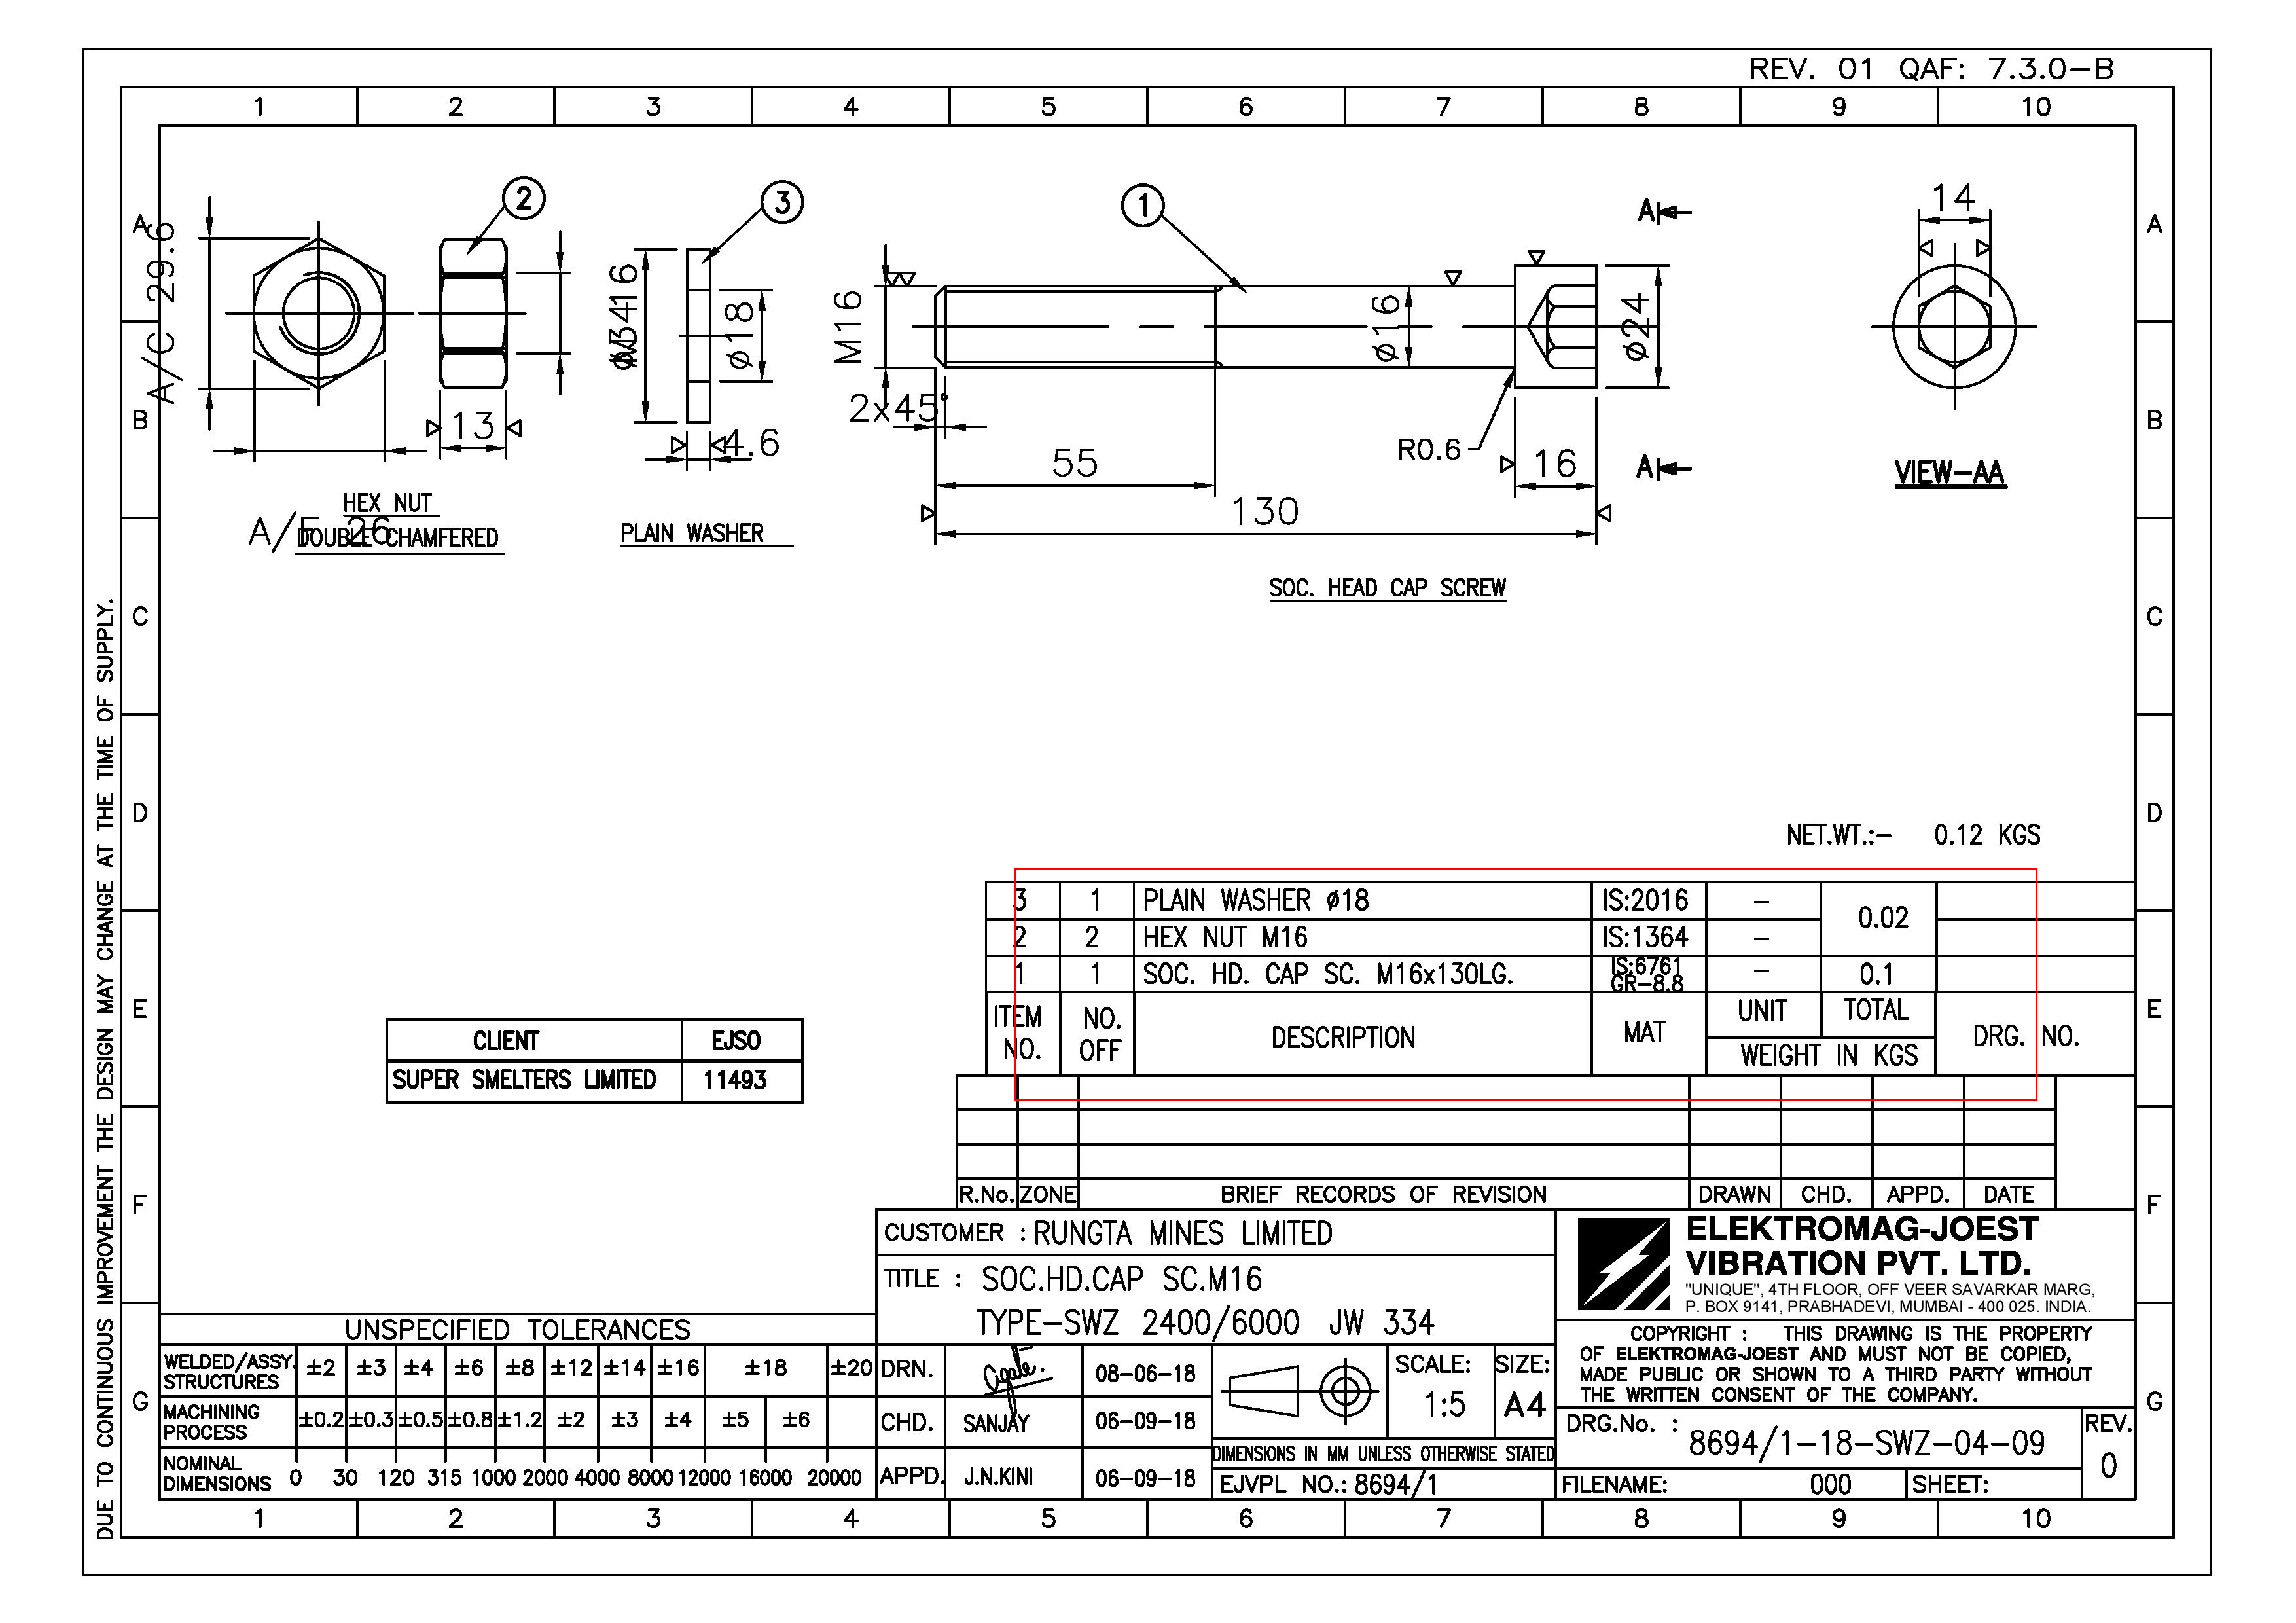

In [ ]:
image_id = 'test_4'

draw_box_pred(image_id, anchors, target_size, loaded_model_50)


array_class_shape =  (1083, 6)
box_xmin =  1551.2883750796318


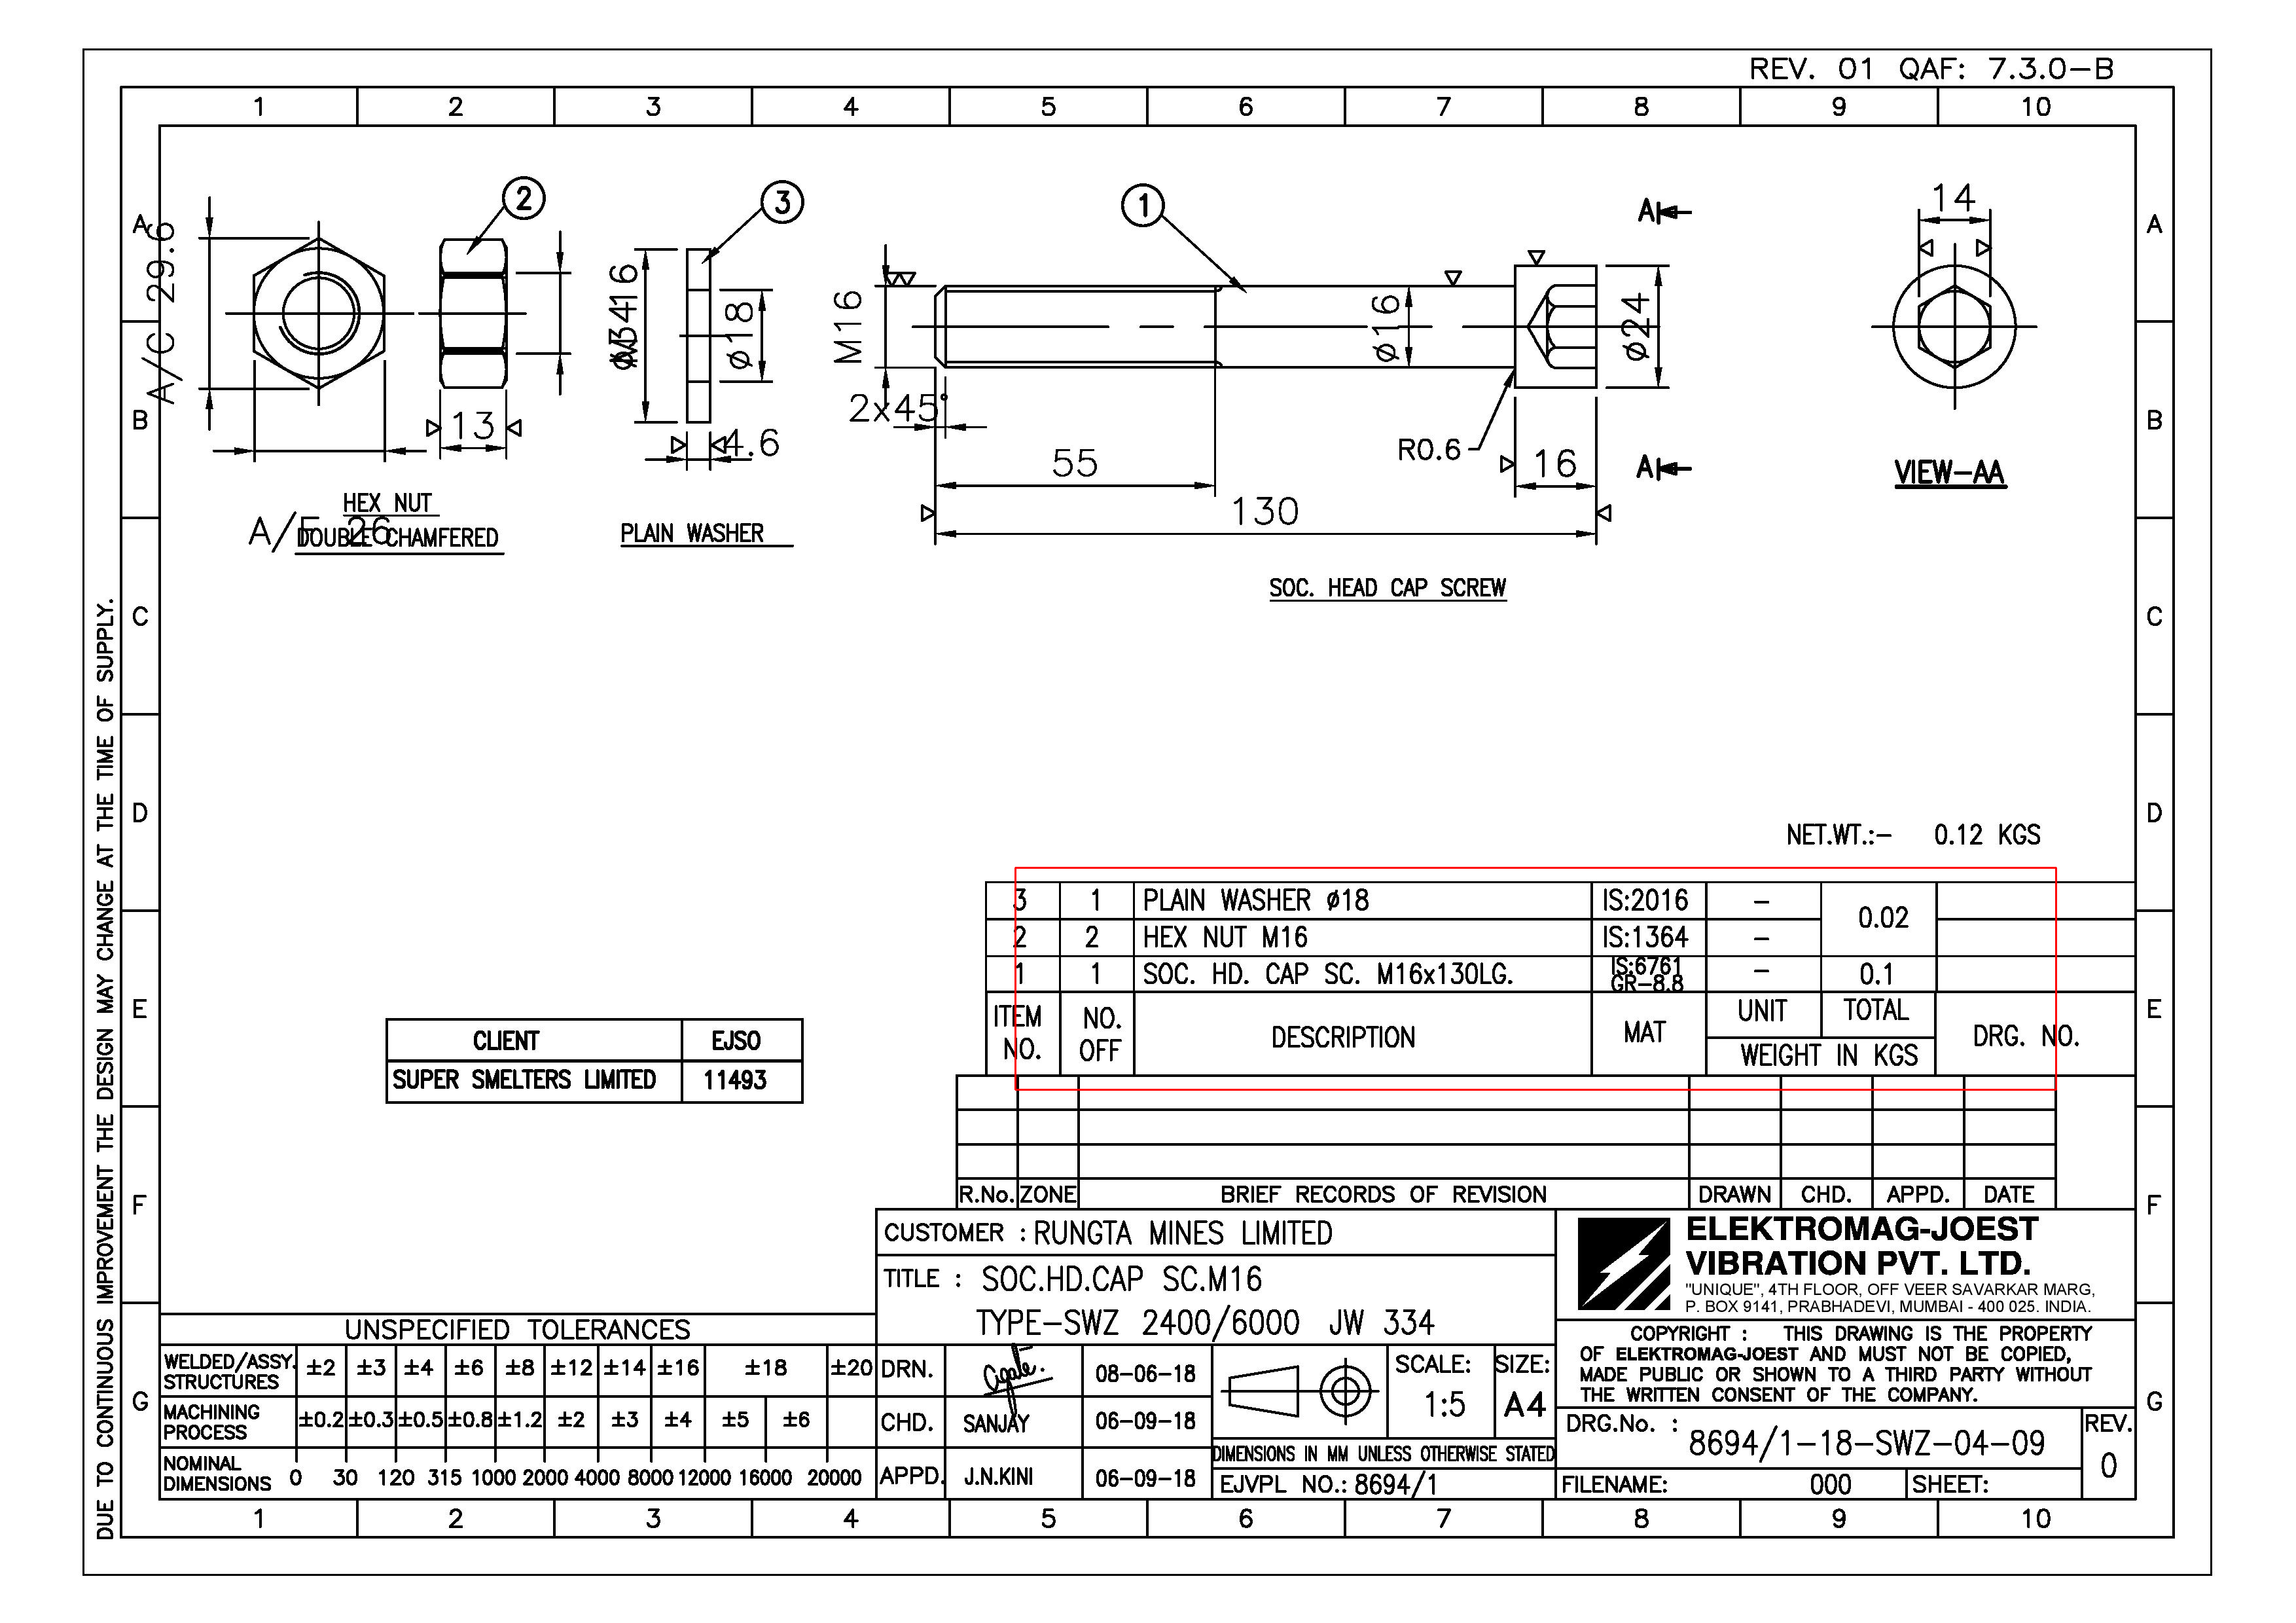

In [ ]:
image_id = 'test_4'

draw_box_pred(image_id, anchors, target_size, loaded_model_50)


array_class_shape =  (1083, 6)
box_xmin =  2043.9144747257233


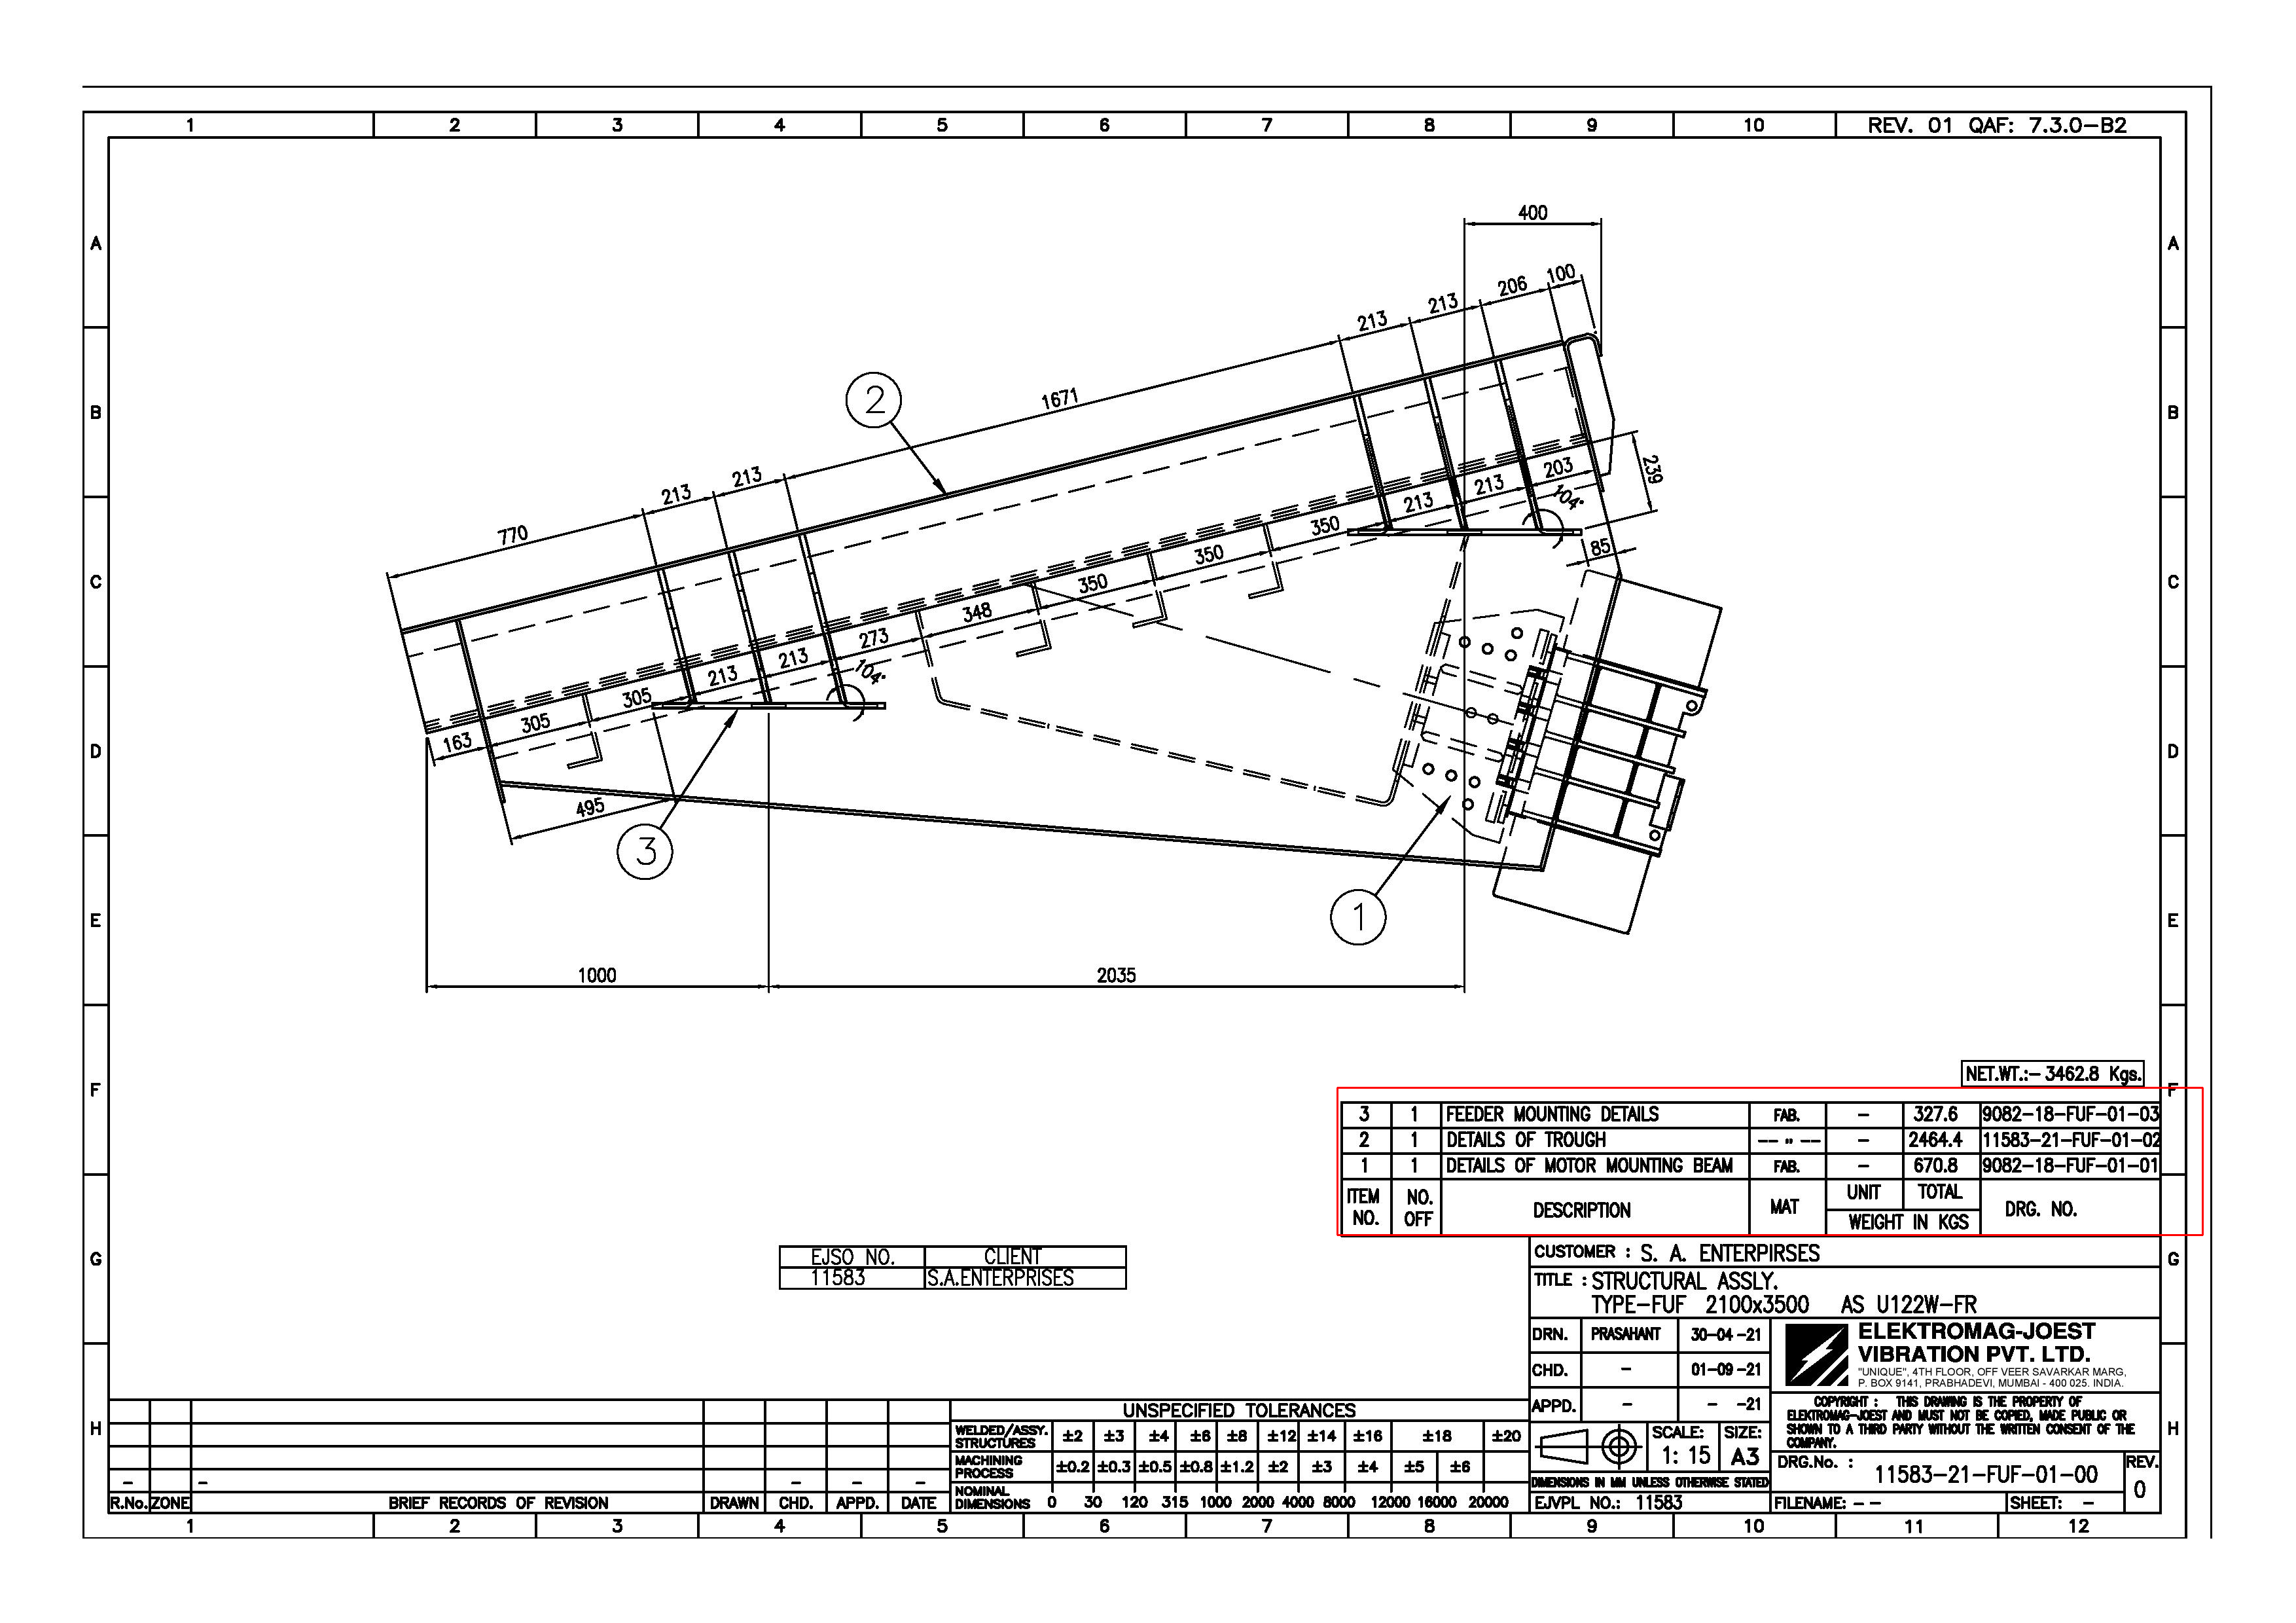

In [ ]:
image_id = 'test_6'

draw_box_pred(image_id, anchors, target_size, loaded_model_50)

array_class_shape =  (1083, 6)
box_xmin =  2043.0285472869873


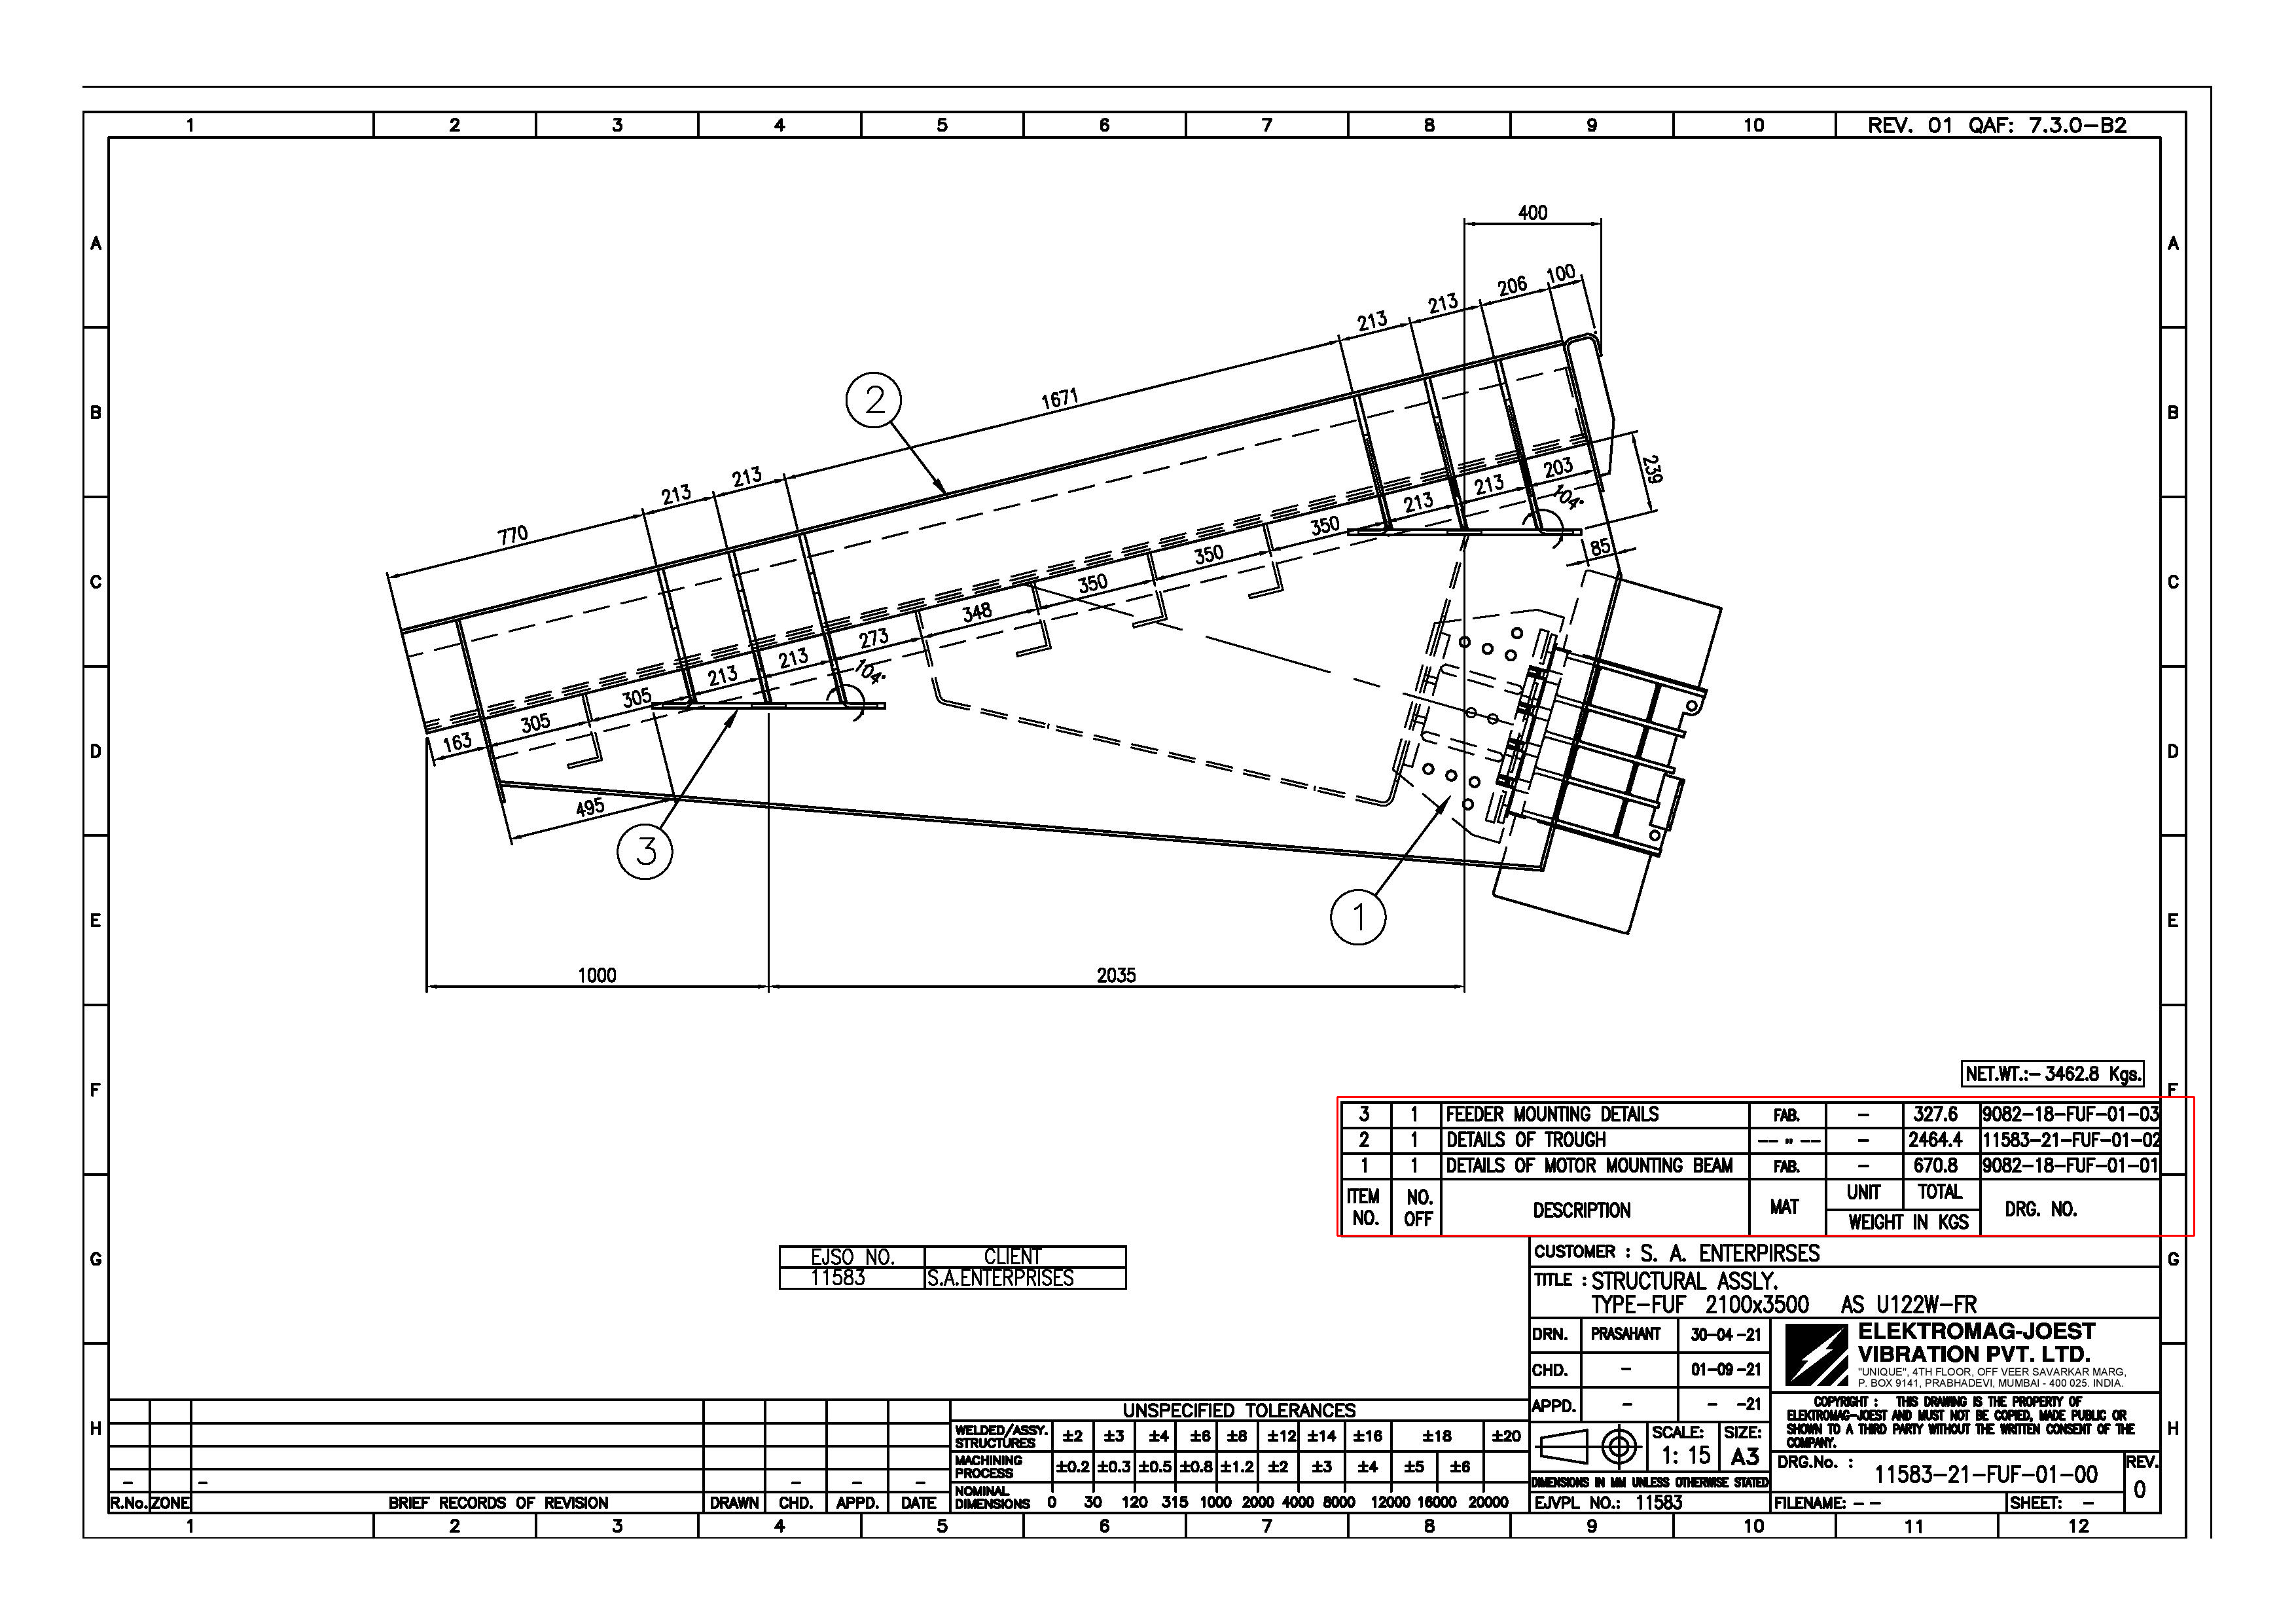

In [ ]:
image_id = 'test_6'

draw_box_pred(image_id, anchors, target_size, loaded_model_50)

In [ ]:
## ================================================================= ALL RESTART ABOVE =======================================================================================================================

In [ ]:
def find_img_resized(image_sl):

  ## imaqge_sl = file name of image i.e. for filename = 101a.jpg, image_sl = 101
  ## my_model = trained model

  image_id = str(image_sl) + '.jpg'

  image_path = '/content/drive/My Drive/drg_test_12/' + image_id
  
  img = cv2.imread(image_path)
  
  height, width, _ = img.shape

  img_resized = cv2.resize(img,(target_size[0], target_size[1]))
    
#  img_resized = unsharp_mask(img_resized)

  return img_resized

In [ ]:
data_val[24]

[182,
 '/content/drive/My Drive/drg_all/512.jpg',
 array([[ 164., 1612., 1790., 2169.]], dtype=float32),
 array([0]),
 3508,
 2479]

In [ ]:
Y_val[24,14, 5]

array([[0.27850628, 0.76260585, 0.46351197, 0.22468738, 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]], dtype=float32)

In [ ]:
img_resized = find_img_resized(512)
anchors = anchors_wrt_target
out_array, pred_1 = pred_img_1(img_resized,anchors, loaded_model_1)
print(out_array[0].shape)
out_array[0][0]

NameError: ignored

In [ ]:
img_resized = find_img_resized(512)
anchors = anchors_wrt_target
out_array, pred_1 = pred_img_1(img_resized,anchors, loaded_model_2)
print(out_array.shape)
out_array[0]

(1083, 6)


array([0.28217328, 0.75575686, 0.45452145, 0.22550674, 0.99637955,
       0.9963483 ], dtype=float32)

In [ ]:
custom_objects = {"loss": my_custom_loss}

In [ ]:
##  r_data_master['img_id'][300].split('.')[0]

loded_model_150 = keras.models.load_model('/content/drive/My Drive/model_1_150', compile = False)

#model = load_model("lc_model.h5", custom_objects={'focal_loss_fixed': focal_loss()})

In [ ]:
print(loaded_model_150.summary())

NameError: ignored

array_class_shape =  (1083, 6)
box_xmin =  2328.206906616688


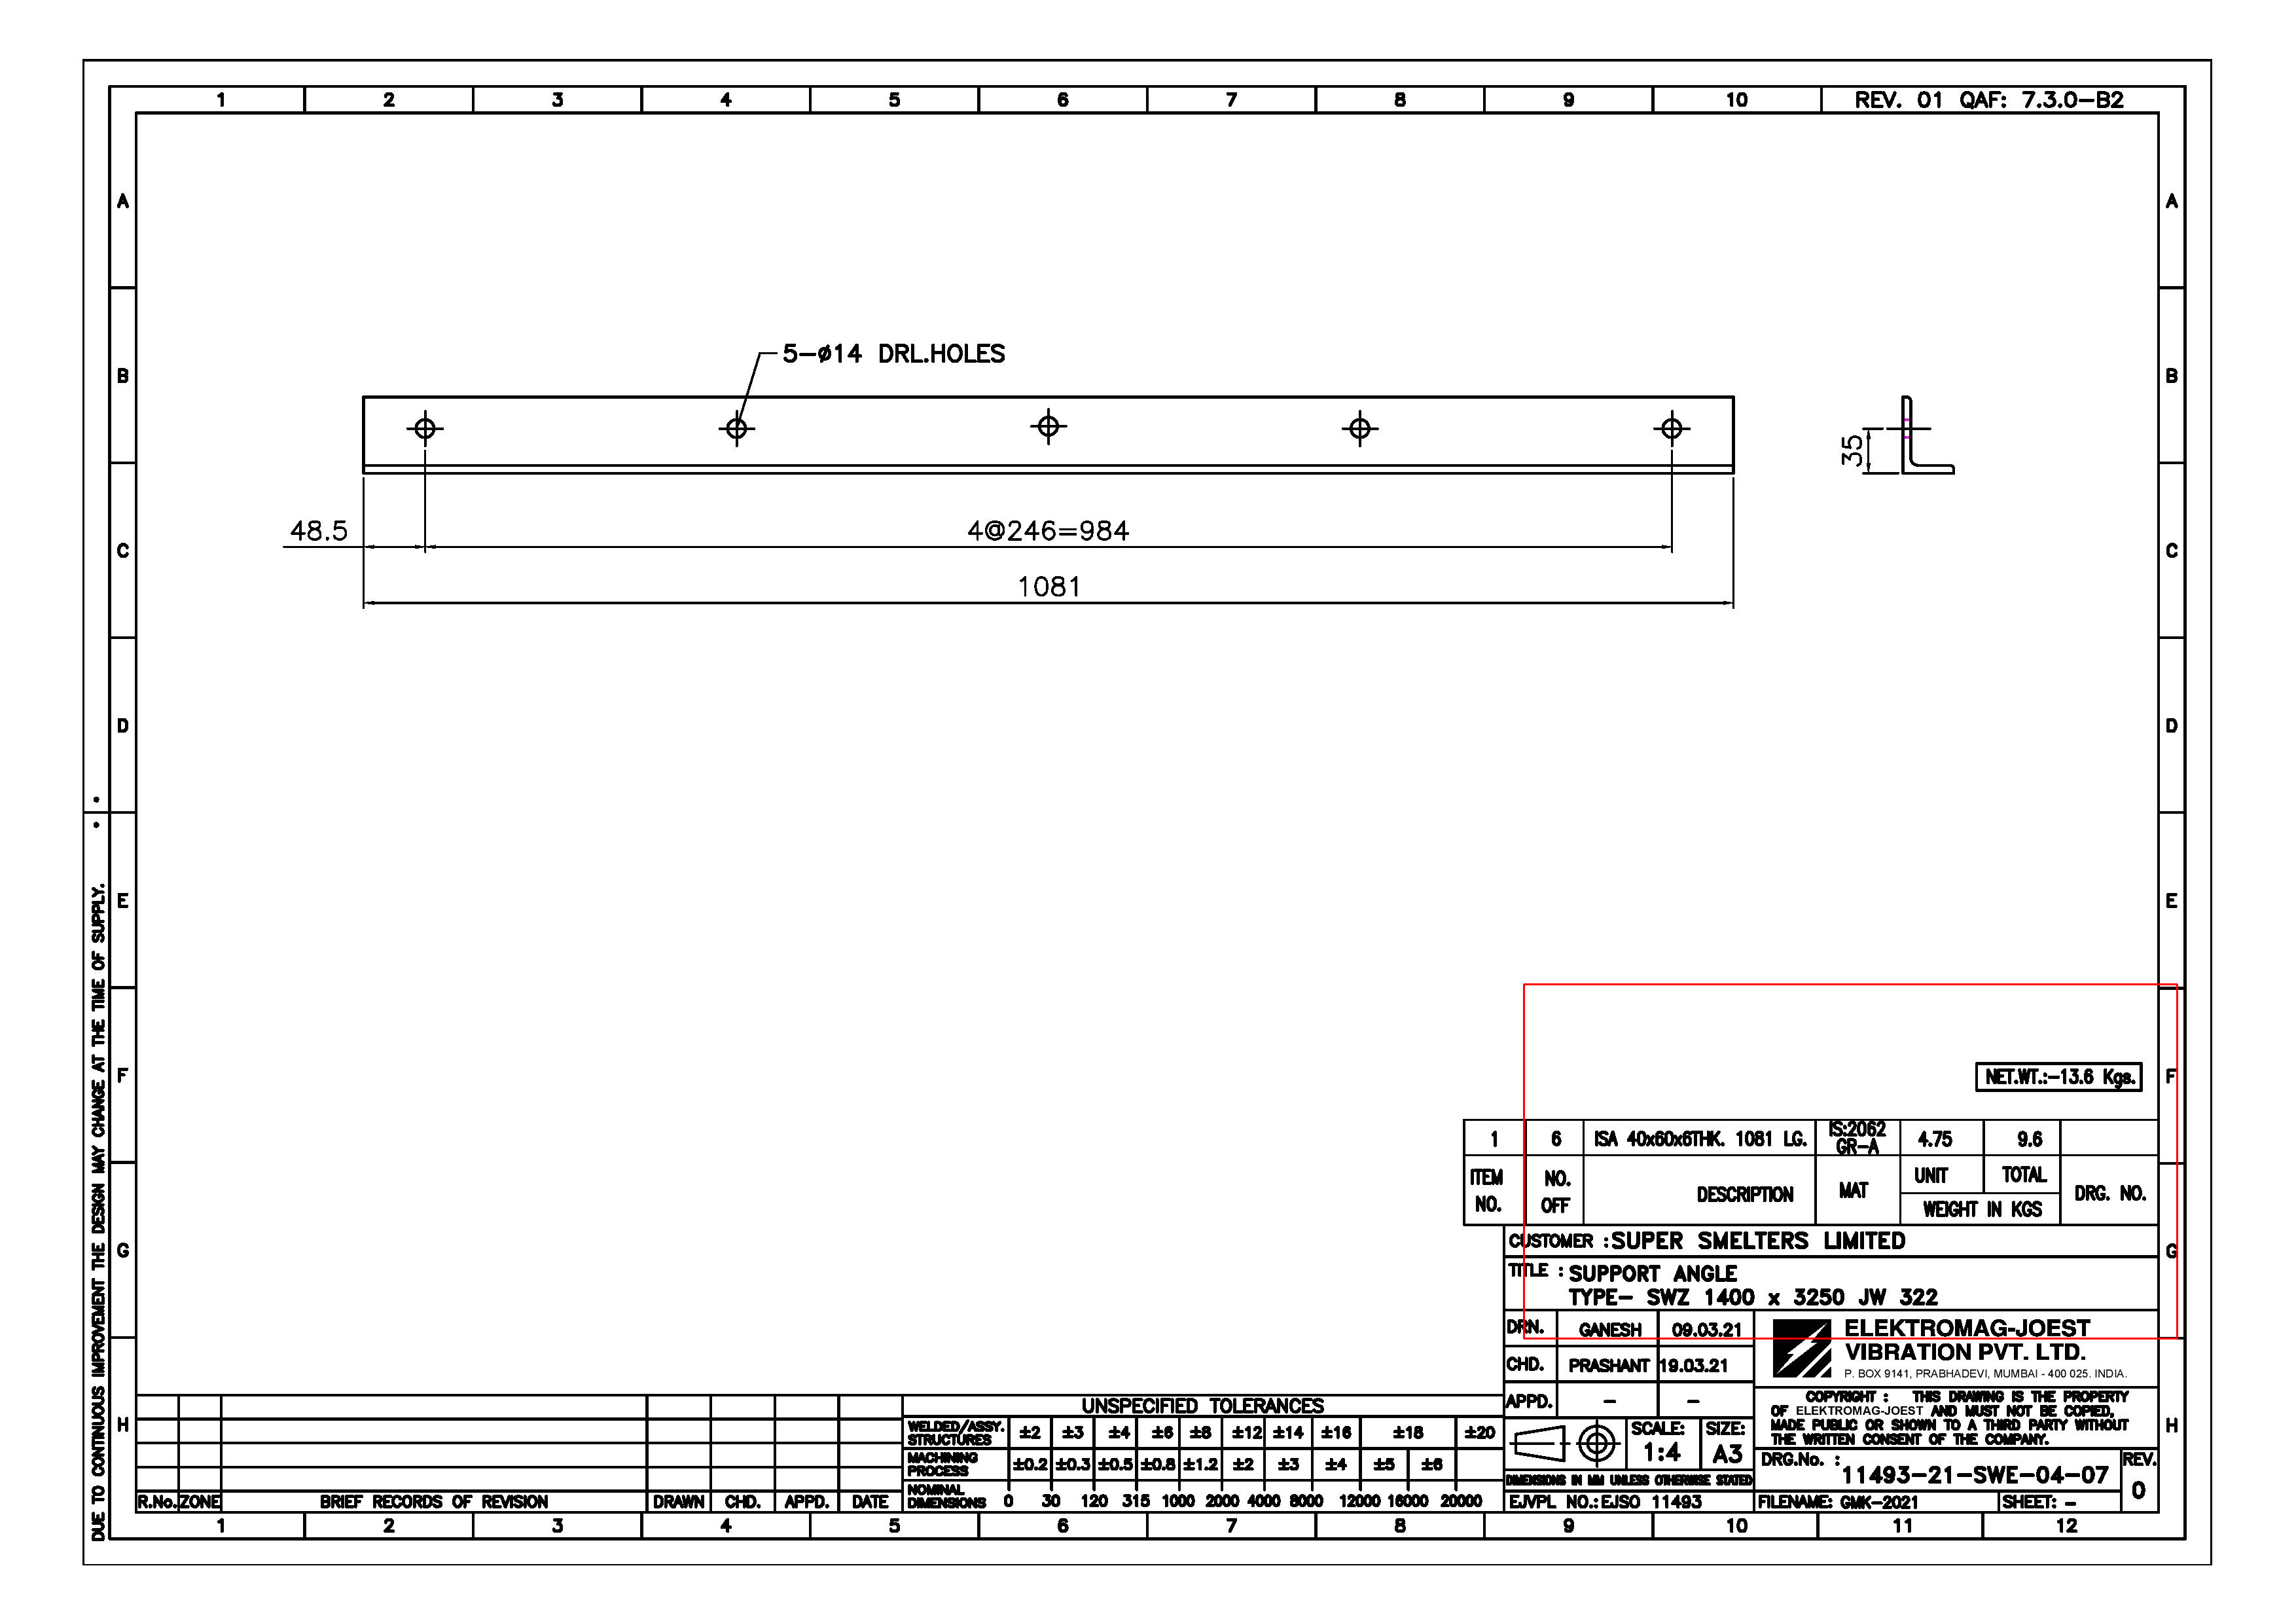

In [ ]:
#anchors = anchors_wrt_target

image_id = 'test_3'

draw_box_pred(image_id, anchors, target_size, loaded_model_50)


In [ ]:
# 5/8 dropout

def make_yolov3_model_drop():
    input_image = Input(shape=(608, 608, 3))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    x = Dropout(0.2)(x)
    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    x = Dropout(0.2)(x)
    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    x = Dropout(0.2)(x)
    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    x = Dropout(0.2)(x)
    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    skip_36 = x
    
    x = Dropout(0.2)(x)
        
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    x = Dropout(0.2)(x)
    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
        
    skip_61 = x
        
    x = Dropout(0.2)(x)
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
    
    # Layer 62 => 65
##    x = _conv_block(x, [{'filter':  256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
##                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
##                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])


    x = Dropout(0.2)(x)
    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
    
     # Layer 66 => 74
##    for i in range(3):
##        x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
##                            {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])

    x = Dropout(0.2)(x)
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
    
    # Layer 75 => 79
##    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
##                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
##                        {'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
##                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
##                        {'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
    
    # Layer 80 => 82
#    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
#                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = Dropout(0.2)(x)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])

    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
    x = Dropout(0.2)(x)

    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 101},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 102},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 103}], skip=False)
    x = Dropout(0.2)(x)

    # Layer 92 => 94
#    yolo_94 = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
#                              {'filter':   18, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

#===============================================================================================================
#    # Layer 95 => 980
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])

    yolo_94 = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True,  'leaky': True,  'layer_idx': 93},
                              {'filter':   18, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 94}], skip=False)


#    # Layer 99 => 106
#    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
#                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
#                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
#                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
#                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
#                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
#                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

#    model = Model(input_image, [yolo_82, yolo_94, yolo_106])

    final = Reshape((grid_y_axis,grid_x_axis,3,6))(yolo_94)
    model = Model(input_image, final)
    return model


In [ ]:
# 19/9 dropout
input_size = (target_w, target_h, 3)


my_model_1 = make_yolov3_model_drop()
my_model_2 = make_yolov3_model_drop()
my_model_3 = make_yolov3_model_drop()
my_model_4 = make_yolov3_model_drop()

print(my_model_1.summary())


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 608, 608, 3) 0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, 608, 608, 32) 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, 608, 608, 32) 0           bnorm_0[0][0]                    
_______________________________________________________________________________________

In [ ]:
epoch = 100
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-4/epoch)

my_model_1.compile(optimizer= opt, loss = my_custom_loss)

In [ ]:
my_model_1.fit(X_train ,Y_train, epochs=100, batch_size = 8, validation_data=(X_val,Y_val))

Epoch 1/100
72/72 [==============================] - 41s 565ms/step - loss: 126.2892 - val_loss: 63.0117
Epoch 2/100
72/72 [==============================] - 39s 544ms/step - loss: 65.0453 - val_loss: 22.0535
Epoch 3/100
72/72 [==============================] - 39s 544ms/step - loss: 37.5779 - val_loss: 20.3219
Epoch 4/100
72/72 [==============================] - 39s 543ms/step - loss: 25.0285 - val_loss: 19.7968
Epoch 5/100
72/72 [==============================] - 39s 543ms/step - loss: 18.6616 - val_loss: 16.5968
Epoch 6/100
72/72 [==============================] - 39s 543ms/step - loss: 14.8228 - val_loss: 11.5860
Epoch 7/100
72/72 [==============================] - 39s 543ms/step - loss: 12.4689 - val_loss: 9.7893
Epoch 8/100
72/72 [==============================] - 39s 544ms/step - loss: 10.1437 - val_loss: 7.8542
Epoch 9/100
72/72 [==============================] - 39s 543ms/step - loss: 8.4921 - val_loss: 6.6654
Epoch 10/100
72/72 [==============================] - 39s 544ms/ste

In [ ]:
 epoch = 100
 opt = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-4/epoch)
 my_model_1.compile(optimizer= opt, loss = my_custom_loss)

my_model_1.fit(X_train ,Y_train, epochs=100, batch_size = 8, validation_data=(X_val,Y_val))

Epoch 1/100
72/72 [==============================] - 40s 557ms/step - loss: 0.1304 - val_loss: 0.4693
Epoch 2/100
72/72 [==============================] - 39s 543ms/step - loss: 0.1147 - val_loss: 0.4660
Epoch 3/100
72/72 [==============================] - 39s 543ms/step - loss: 0.1166 - val_loss: 0.4782
Epoch 4/100
72/72 [==============================] - 39s 543ms/step - loss: 0.1125 - val_loss: 0.4758
Epoch 5/100
72/72 [==============================] - 39s 543ms/step - loss: 0.1075 - val_loss: 0.3850
Epoch 6/100
72/72 [==============================] - 39s 543ms/step - loss: 0.0945 - val_loss: 0.5063
Epoch 7/100
72/72 [==============================] - 39s 542ms/step - loss: 0.0989 - val_loss: 0.4461
Epoch 8/100
72/72 [==============================] - 39s 543ms/step - loss: 0.0962 - val_loss: 0.4777
Epoch 9/100
72/72 [==============================] - 39s 543ms/step - loss: 0.0944 - val_loss: 0.4202
Epoch 10/100
72/72 [==============================] - 39s 543ms/step - loss: 0.086

In [ ]:
epoch = 200
opt = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5/epoch)

my_model_1.compile(optimizer= opt, loss = my_custom_loss)

my_model_1.fit(X_train ,Y_train, epochs=200, batch_size = 8, validation_data=(X_val,Y_val))

Epoch 1/200
49/49 [==============================] - 28s 574ms/step - loss: 0.0173 - val_loss: 0.2277
Epoch 2/200
49/49 [==============================] - 27s 554ms/step - loss: 0.0180 - val_loss: 0.1971
Epoch 3/200
49/49 [==============================] - 27s 553ms/step - loss: 0.0140 - val_loss: 0.1514
Epoch 4/200
49/49 [==============================] - 27s 554ms/step - loss: 0.0137 - val_loss: 0.1795
Epoch 5/200
49/49 [==============================] - 27s 554ms/step - loss: 0.0126 - val_loss: 0.1481
Epoch 6/200
49/49 [==============================] - 27s 554ms/step - loss: 0.0100 - val_loss: 0.1544
Epoch 7/200
49/49 [==============================] - 27s 554ms/step - loss: 0.0116 - val_loss: 0.1646
Epoch 8/200
49/49 [==============================] - 27s 554ms/step - loss: 0.0104 - val_loss: 0.1779
Epoch 9/200
49/49 [==============================] - 27s 554ms/step - loss: 0.0113 - val_loss: 0.1617
Epoch 10/200
49/49 [==============================] - 27s 552ms/step - loss: 0.009

In [ ]:
# keras library import  for Saving and loading model and weights

from keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_drg_json_115 = loaded_model_1.to_json()


with open("model_drg_num_115.json", "w") as json_file:
    json_file.write(model_drg_json_115)

# serialize weights to HDF5
loaded_model_1.save_weights("model_drg_num_115.h5")

In [ ]:
# keras library import  for Saving and loading model and weights

from keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_drg_json_115 = my_model_1.to_json()


with open("/content/drive/My Drive/model_drg_num_115.json", "w") as json_file:
    json_file.write(model_drg_json_115)

# serialize weights to HDF5
### loaded_model_1.save_weights("model_drg_num_115.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
epoch = 200
opt = Adam(lr=0.000001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6/epoch)

my_model_1.compile(optimizer= opt, loss = my_custom_loss)

my_model_1.fit(X_train ,Y_train, epochs=200, batch_size = 8, validation_data=(X_val,Y_val))

Epoch 1/200
49/49 [==============================] - 28s 574ms/step - loss: 0.0021 - val_loss: 0.0610
Epoch 2/200
49/49 [==============================] - 27s 554ms/step - loss: 0.0023 - val_loss: 0.0588
Epoch 3/200
49/49 [==============================] - 27s 553ms/step - loss: 0.0022 - val_loss: 0.0572
Epoch 4/200
49/49 [==============================] - 27s 553ms/step - loss: 0.0023 - val_loss: 0.0573
Epoch 5/200
49/49 [==============================] - 27s 553ms/step - loss: 0.0023 - val_loss: 0.0529
Epoch 6/200
49/49 [==============================] - 27s 554ms/step - loss: 0.0021 - val_loss: 0.0539
Epoch 7/200
49/49 [==============================] - 27s 553ms/step - loss: 0.0021 - val_loss: 0.0530
Epoch 8/200
49/49 [==============================] - 27s 554ms/step - loss: 0.0023 - val_loss: 0.0529
Epoch 9/200
49/49 [==============================] - 27s 554ms/step - loss: 0.0022 - val_loss: 0.0522
Epoch 10/200
49/49 [==============================] - 27s 554ms/step - loss: 0.002

In [ ]:
# load json and create model
json_file = open('/content/drive/My Drive/model_drg_num_115.json', 'r')

loaded_model_json = json_file.read()
json_file.close()
loaded_model_1 = model_from_json(loaded_model_json)

# load weights into new model
## loaded_model_1.load_weights("/content/drive/My Drive/model_drg_num_114.h5")
print("Loaded model from disk")

print(loaded_model_1.summary())

Loaded model from disk
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 608, 608, 3) 0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, 608, 608, 32) 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, 608, 608, 32) 0           bnorm_0[0][0]                    
_______________________________________________________________________

In [ ]:
epoch = 200
opt = Adam(lr=0.000001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6/epoch)

loaded_model_1.compile(optimizer= opt, loss = my_custom_loss)

loaded_model_1.fit(X_train ,Y_train, epochs=200, batch_size = 8, validation_data=(X_val,Y_val))

Epoch 1/200
49/49 [==============================] - 53s 1s/step - loss: 0.0070 - val_loss: 0.0118
Epoch 2/200
49/49 [==============================] - 51s 1s/step - loss: 0.0072 - val_loss: 0.0129
Epoch 3/200
49/49 [==============================] - 52s 1s/step - loss: 0.0033 - val_loss: 0.0128
Epoch 4/200
49/49 [==============================] - 54s 1s/step - loss: 0.0023 - val_loss: 0.0123
Epoch 5/200
49/49 [==============================] - 55s 1s/step - loss: 0.0027 - val_loss: 0.0121
Epoch 6/200
49/49 [==============================] - 55s 1s/step - loss: 0.0030 - val_loss: 0.0118
Epoch 7/200
49/49 [==============================] - 55s 1s/step - loss: 0.0024 - val_loss: 0.0121
Epoch 8/200
49/49 [==============================] - 55s 1s/step - loss: 0.0020 - val_loss: 0.0118
Epoch 9/200
49/49 [==============================] - 55s 1s/step - loss: 0.0030 - val_loss: 0.0120
Epoch 10/200
49/49 [==============================] - 55s 1s/step - loss: 0.0020 - val_loss: 0.0120
Epoch 11/

In [ ]:
loaded_model_1.fit(X_train ,Y_train, epochs=200, batch_size = 8, validation_data=(X_val,Y_val))

Epoch 1/200
49/49 [==============================] - 49s 1s/step - loss: 0.0015 - val_loss: 0.0086
Epoch 2/200
49/49 [==============================] - 51s 1s/step - loss: 0.0013 - val_loss: 0.0088
Epoch 3/200
49/49 [==============================] - 52s 1s/step - loss: 0.0013 - val_loss: 0.0092
Epoch 4/200
49/49 [==============================] - 53s 1s/step - loss: 0.0014 - val_loss: 0.0093
Epoch 5/200
49/49 [==============================] - 54s 1s/step - loss: 0.0014 - val_loss: 0.0084
Epoch 6/200
49/49 [==============================] - 54s 1s/step - loss: 0.0014 - val_loss: 0.0086
Epoch 7/200
49/49 [==============================] - 54s 1s/step - loss: 0.0013 - val_loss: 0.0090
Epoch 8/200
49/49 [==============================] - 55s 1s/step - loss: 0.0014 - val_loss: 0.0082
Epoch 9/200
49/49 [==============================] - 55s 1s/step - loss: 0.0015 - val_loss: 0.0082
Epoch 10/200
49/49 [==============================] - 54s 1s/step - loss: 0.0013 - val_loss: 0.0082
Epoch 11/